In [46]:
# General
import pandas as pd
import numpy as np
from time import time
from pprint import PrettyPrinter
import pickle

# Data Tools
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Models
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMClassifier

# Plotting Tools
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
%matplotlib inline
pp = PrettyPrinter()

In [47]:
df = pd.read_csv('../data/telco_churn_numeric.csv')

In [48]:
# Seperate Train and Test
full_target = df['Churn']
train_cols = [col for col in df.columns[1:] if col != 'Churn']
full_train = df[train_cols]

# Standardize
scaler = StandardScaler()
full_train = pd.DataFrame(scaler.fit_transform(full_train), columns=full_train.columns)

# Train Test Split
train_x, test_x, train_y, test_y = train_test_split(full_train, full_target, random_state=42)

In [150]:
def grid_classifier(model, train, target, parameters={}, cv=5, timed=True, feat_imp=False):
    '''
    For tuning models.
    
    Automatically plots CV results, but this requires training over on parameter at a time.
    If the parameters argument stays an empty dictionary then no plot is made (duh...)
    
    Returns the GridSearch object
    
        Parameters:
        -----------
    model - model
    train - array of training data
    target - array of target data
    parameters - dict of parameters the GSearcher will run over
    cv - int, k-fold number
    timed - boolean, gives printout of timings
    
        Returns :
        ---------
    gsearcher - fitted and searched GridSearchCV object
    '''
    if timed:
        start = time()
    
    # Grid Search
    gsearcher = GridSearchCV(
        estimator=model, 
        param_grid=parameters,
        scoring='roc_auc',
        n_jobs=-1,
        cv=cv,
        return_train_score=True
    )
    gsearcher.fit(train, target)
    results = gsearcher.cv_results_
    
    if timed:
        passed = time() - start
        print(f'Seconds to fit: {passed:.2f}')

    # Print Report
    print('Grid Scores: \n')
    pp.pprint(results)
    print(f'Best Model Parameters: {gsearcher.best_params_}')
    print(f'Best Model Score: {gsearcher.best_score_:.4f}')
    
    # Plot CV Results
    if parameters:
        test_means = results['mean_test_score']
        train_means = results['mean_train_score']
        x = range(len(test_means))
        model_name = str(model.__class__).split('.')[-1][:-2]
        param = list(results['params'][0].keys())[0]
        labels = [str(pair[param]) for pair in results['params']]

        plt.figure(figsize=(10, 8))
        plt.plot(x, test_means, label='Test', color='blue')
        plt.plot(x, train_means, label='Train', color='green')
        plt.title(f'{model_name} over {param}')
        plt.xlabel(param)
        plt.ylabel('AUC Scores')
        plt.xticks(x, labels, rotation=60)
        plt.legend()
    
    # Plot Feature Importance
    if feat_imp:
        best_model = gsearcher.best_estimator_
        best_model.fit(train, target)
        feat_series = pd.Series(best_model.feature_importances_, index=train.columns)
        feat_series.sort_values(ascending=False, inplace=True)

        plt.figure(figsize=(10, 8))
        feat_series.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        plt.xticks(rotation=60)        
    
    return gsearcher

## Modeling
### Sklearn GBM
#### Baseline

Seconds to fit: 0.95
Grid Scores: 

{'mean_fit_time': array([0.29887133]),
 'mean_score_time': array([0.00278049]),
 'mean_test_score': array([0.84391466]),
 'mean_train_score': array([0.93974273]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.85986138]),
 'split0_train_score': array([0.94052219]),
 'split1_test_score': array([0.85110652]),
 'split1_train_score': array([0.93954276]),
 'split2_test_score': array([0.83538818]),
 'split2_train_score': array([0.93679986]),
 'split3_test_score': array([0.82212321]),
 'split3_train_score': array([0.9428145]),
 'split4_test_score': array([0.85104852]),
 'split4_train_score': array([0.93903433]),
 'std_fit_time': array([0.06470259]),
 'std_score_time': array([0.00078025]),
 'std_test_score': array([0.01345133]),
 'std_train_score': array([0.00196192])}
Best Model Parameters: {}
Best Model Score: 0.8439


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

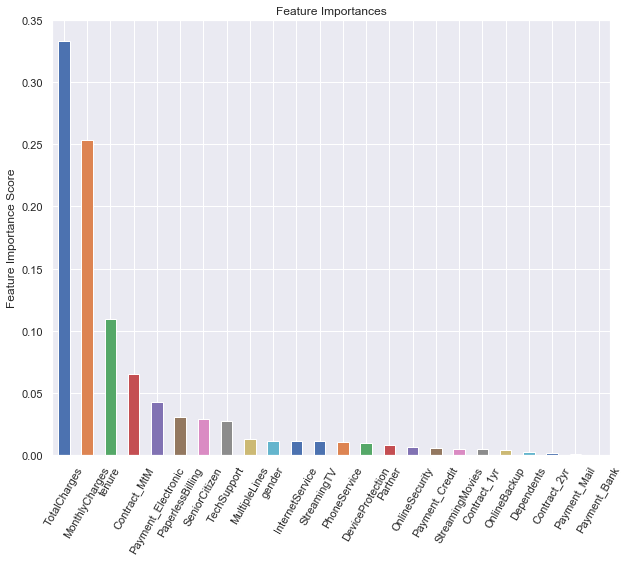

In [131]:
model = GradientBoostingClassifier(random_state=42)

grid_classifier(model, test_x, test_y, feat_imp=True)

#### N_estimators

Seconds to fit: 12.83
Grid Scores: 

{'mean_fit_time': array([0.08856273, 0.12467666, 0.1725307 , 0.21946959, 0.26023054,
       0.30570135, 0.36356869, 0.36755009, 0.41270018, 0.46226244,
       0.51762342, 0.59171677, 0.75641079, 0.62612967, 0.59098778,
       0.65058231, 0.98152561, 0.81421499, 0.72994442]),
 'mean_score_time': array([0.00320764, 0.00287619, 0.00279331, 0.0027184 , 0.002913  ,
       0.003023  , 0.00310612, 0.00281372, 0.00278296, 0.00391145,
       0.00383282, 0.00473156, 0.00886521, 0.00452976, 0.00387607,
       0.00407085, 0.00583339, 0.0063272 , 0.00488291]),
 'mean_test_score': array([0.8342935 , 0.83819609, 0.83967809, 0.84157189, 0.8426537 ,
       0.84344436, 0.84416658, 0.84418888, 0.84420688, 0.84412642,
       0.84413747, 0.84354598, 0.84365727, 0.84364019, 0.84380143,
       0.84327693, 0.84294463, 0.84302819, 0.84284982]),
 'mean_train_score': array([0.84145413, 0.84718492, 0.85189262, 0.85612056, 0.85918704,
       0.86166068, 0.86364079, 0.86562869, 

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': range(10, 101, 5)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

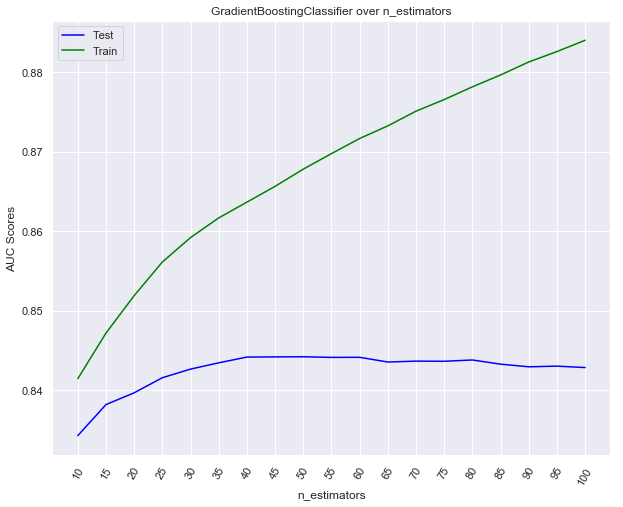

In [51]:
model = GradientBoostingClassifier(random_state=42)

parameters = {'n_estimators': range(10, 101, 5)}

grid_classifier(model, train_x, train_y, parameters)

#### Max Depth
Leaving this alone, looks like an overfit, default is None

Seconds to fit: 25.73
Grid Scores: 

{'mean_fit_time': array([0.37544799, 0.83878598, 0.92118239, 1.18305674, 1.54732342,
       2.15257268, 2.99238892, 4.00301714, 4.72077188]),
 'mean_score_time': array([0.00547938, 0.00533385, 0.003547  , 0.00394239, 0.00418901,
       0.0047308 , 0.00629225, 0.00837197, 0.00585585]),
 'mean_test_score': array([0.84420688, 0.84289957, 0.83941243, 0.83456711, 0.83054923,
       0.82392258, 0.82232328, 0.8142346 , 0.80973767]),
 'mean_train_score': array([0.86778826, 0.88924492, 0.91843663, 0.94913833, 0.97713651,
       0.99304294, 0.99895704, 0.99990585, 0.9999892 ]),
 'param_max_depth': masked_array(data=[3, 4, 5, 6, 7, 8, 9, 10, 11],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object),
 'params': [{'max_depth': 3},
            {'max_depth': 4},
            {'max_depth': 5},
            {'max_depth': 6},
            {'max_depth': 7},
            {'max

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(3, 12)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='roc_auc', verbose=0)

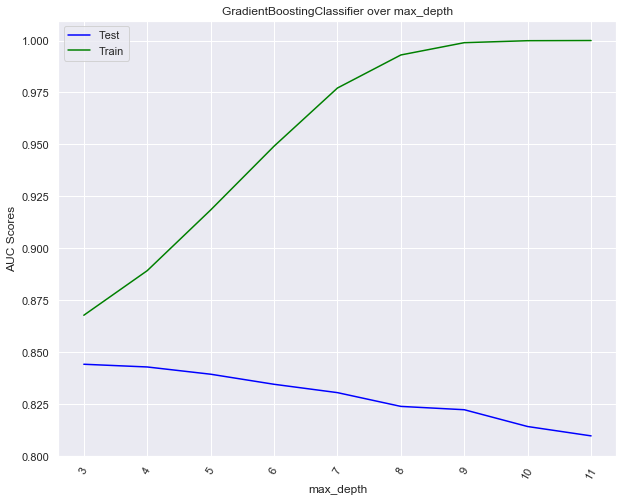

In [52]:
model = GradientBoostingClassifier(
    random_state=42,
    n_estimators=50
)

parameters = {'max_depth': range(3, 12)}

grid_classifier(model, train_x, train_y, parameters)

#### Min Samples Split
Leaving this alone as well, default is 2 and not a tremendous amount of variance in these scores

Seconds to fit: 12.92
Grid Scores: 

{'mean_fit_time': array([0.37915392, 0.40453024, 0.36685834, 0.38092542, 0.36533298,
       0.34959159, 0.35092421, 0.34946012, 0.368187  , 0.36118779,
       0.35055041, 0.36356821, 0.37426839, 0.34167352, 0.35617161,
       0.36211028, 0.35003586, 0.37363157, 0.36236701, 0.36590433,
       0.35717182, 0.35949726, 0.34530201, 0.35018439, 0.36375837,
       0.38935299]),
 'mean_score_time': array([0.00513992, 0.00342469, 0.00287018, 0.00342588, 0.00299802,
       0.00289478, 0.00310378, 0.004918  , 0.0035439 , 0.00285988,
       0.00283775, 0.00289273, 0.00304532, 0.00279469, 0.00293021,
       0.00372038, 0.00371904, 0.00260191, 0.00295472, 0.00303016,
       0.00352778, 0.00301857, 0.00288801, 0.00293784, 0.00300803,
       0.00299997]),
 'mean_test_score': array([0.84420688, 0.84454008, 0.84444497, 0.8442897 , 0.84431234,
       0.84435671, 0.84442461, 0.84448054, 0.84446021, 0.84445097,
       0.84445097, 0.84445097, 0.84445097, 0.84448146, 0.84

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'min_samples_split': range(2, 103, 4)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

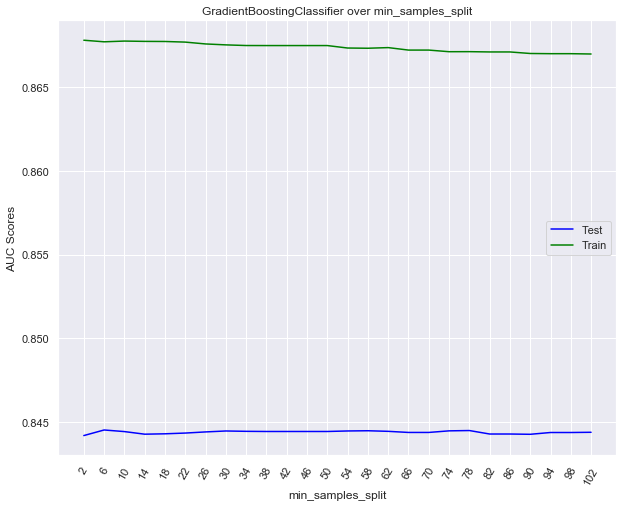

In [54]:
model = GradientBoostingClassifier(
    random_state=42,
    n_estimators=50
)

parameters = {'min_samples_split': range(2, 103, 4)}

grid_classifier(model, train_x, train_y, parameters)

#### Min Samples Leaf

Seconds to fit: 9.90
Grid Scores: 

{'mean_fit_time': array([0.36728106, 0.35772858, 0.36762376, 0.38632026, 0.36054678,
       0.36475167, 0.34617782, 0.358038  , 0.35990758, 0.36458578,
       0.35783019, 0.3621172 , 0.34852762, 0.35528359, 0.34717202,
       0.35589681, 0.35097218, 0.34385629, 0.3618752 , 0.32651539]),
 'mean_score_time': array([0.00397797, 0.00437479, 0.00341959, 0.00305152, 0.00312934,
       0.00293965, 0.00310798, 0.00311537, 0.00294042, 0.00374351,
       0.00326319, 0.00310373, 0.00476241, 0.00354753, 0.00306458,
       0.00307527, 0.00303473, 0.00309672, 0.00296912, 0.00261526]),
 'mean_test_score': array([0.84394025, 0.84369985, 0.84303392, 0.84414993, 0.84424007,
       0.84384132, 0.84410052, 0.84412223, 0.84435602, 0.84430434,
       0.84446842, 0.84412549, 0.84424474, 0.84477712, 0.84487786,
       0.84486448, 0.84482011, 0.84507471, 0.84483256, 0.84436028]),
 'mean_train_score': array([0.86698997, 0.86662522, 0.86639779, 0.86611889, 0.86590093,
       0

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'min_samples_leaf': range(5, 101, 5)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

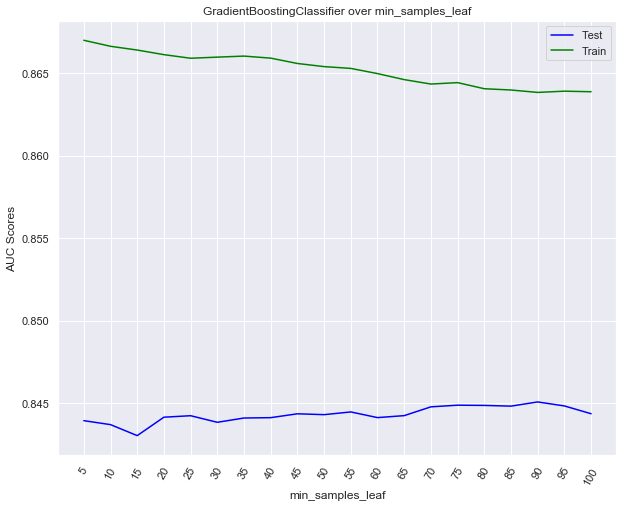

In [56]:
model = GradientBoostingClassifier(
    random_state=42,
    n_estimators=50
)

parameters = {'min_samples_leaf': range(5, 101, 5)}

grid_classifier(model, train_x, train_y, parameters)

#### Max Features

Seconds to fit: 1.82
Grid Scores: 

{'mean_fit_time': array([0.15067005, 0.14787202, 0.15809355, 0.16805925, 0.18727722,
       0.16613126]),
 'mean_score_time': array([0.00415874, 0.0034586 , 0.00311303, 0.00493231, 0.00369143,
       0.00262985]),
 'mean_test_score': array([0.84262715, 0.84314584, 0.84428413, 0.84405071, 0.84452211,
       0.84342547]),
 'mean_train_score': array([0.85739535, 0.85851378, 0.85907595, 0.86027214, 0.86076695,
       0.8611722 ]),
 'param_max_features': masked_array(data=[4, 5, 6, 7, 8, 9],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'max_features': 4},
            {'max_features': 5},
            {'max_features': 6},
            {'max_features': 7},
            {'max_features': 8},
            {'max_features': 9}],
 'rank_test_score': array([6, 5, 2, 3, 1, 4], dtype=int32),
 'split0_test_score': array([0.8657336 , 0.86554659, 0.86459767, 0.86539421, 0.86432061,
       0.863

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=90, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_features': range(4, 10)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='roc_auc', verbose=0)

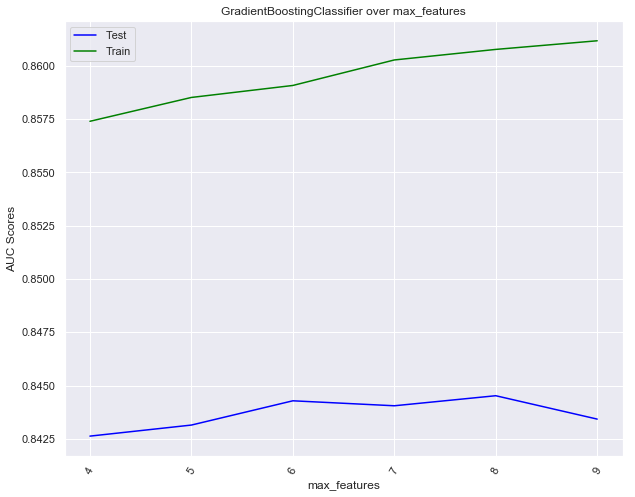

In [57]:
model = GradientBoostingClassifier(
    random_state=42,
    n_estimators=50,
    min_samples_leaf=90,
)

parameters = {'max_features': range(4, 10)}

grid_classifier(model, train_x, train_y, parameters)

#### Learning Rate
Increase and decrease the learning rate in proportion to the trees. 

Results:

| factor | trees | rate  | AUC    |
|--------|-------|-------|--------|
| 2/3    | 33    | 0.15  | 0.8449 |
| 1      | 50    | 0.1   | 0.8445 |
| 1.5    | 75    | 0.067 | 0.8447 |
| 2      | 100   | 0.05  | 0.8449 |
| 4      | 200   | 0.025 | 0.8449 |

So it looks like the learning rate didn't need tuning, sticking with default of 0.1

In [59]:
model = GradientBoostingClassifier(
    random_state=42,
    n_estimators=33,
    min_samples_leaf=90,
    max_features=8,
    learning_rate=0.15
)

grid_classifier(model, train_x, train_y)

Seconds to fit: 0.51
Grid Scores: 

{'mean_fit_time': array([0.13933253]),
 'mean_score_time': array([0.00360417]),
 'mean_test_score': array([0.84488709]),
 'mean_train_score': array([0.86047729]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.86591831]),
 'split0_train_score': array([0.85551771]),
 'split1_test_score': array([0.84364755]),
 'split1_train_score': array([0.86081272]),
 'split2_test_score': array([0.83482366]),
 'split2_train_score': array([0.8631007]),
 'split3_test_score': array([0.83630088]),
 'split3_train_score': array([0.86273395]),
 'split4_test_score': array([0.8437263]),
 'split4_train_score': array([0.86022136]),
 'std_fit_time': array([0.03031874]),
 'std_score_time': array([0.00135551]),
 'std_test_score': array([0.01113891]),
 'std_train_score': array([0.0027111])}
Best Model Parameters: {}
Best Model Score: 0.8449


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.15, loss='deviance', max_depth=3,
              max_features=8, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=90, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=33,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [62]:
model = GradientBoostingClassifier(
    random_state=42,
    n_estimators=50,
    min_samples_leaf=90,
    max_features=8,
    learning_rate=0.1
)

grid_classifier(model, train_x, train_y)

Seconds to fit: 0.68
Grid Scores: 

{'mean_fit_time': array([0.19077821]),
 'mean_score_time': array([0.00388198]),
 'mean_test_score': array([0.84452211]),
 'mean_train_score': array([0.86076695]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.86432061]),
 'split0_train_score': array([0.85604823]),
 'split1_test_score': array([0.84313037]),
 'split1_train_score': array([0.86048975]),
 'split2_test_score': array([0.83539467]),
 'split2_train_score': array([0.86383104]),
 'split3_test_score': array([0.83494618]),
 'split3_train_score': array([0.86209529]),
 'split4_test_score': array([0.84480128]),
 'split4_train_score': array([0.86137044]),
 'std_fit_time': array([0.03653341]),
 'std_score_time': array([0.00100536]),
 'std_test_score': array([0.01066922]),
 'std_train_score': array([0.00260233])}
Best Model Parameters: {}
Best Model Score: 0.8445


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=8, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=90, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [180]:
model = GradientBoostingClassifier(
    random_state=42,
    n_estimators=75,
    min_samples_leaf=90,
    max_features=8,
    learning_rate=0.067
)

grid_classifier(model, train_x, train_y)

Seconds to fit: 1.05
Grid Scores: 

{'mean_fit_time': array([0.31052141]),
 'mean_score_time': array([0.00468278]),
 'mean_test_score': array([0.84466774]),
 'mean_train_score': array([0.86127403]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.86472003]),
 'split0_train_score': array([0.8565542]),
 'split1_test_score': array([0.84202445]),
 'split1_train_score': array([0.8617302]),
 'split2_test_score': array([0.8352444]),
 'split2_train_score': array([0.86356392]),
 'split3_test_score': array([0.8366569]),
 'split3_train_score': array([0.86274781]),
 'split4_test_score': array([0.84467644]),
 'split4_train_score': array([0.86177402]),
 'std_fit_time': array([0.05565513]),
 'std_score_time': array([0.0012449]),
 'std_test_score': array([0.01060405]),
 'std_train_score': array([0.00245562])}
Best Model Parameters: {}
Best Model Score: 0.8447


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.067, loss='deviance', max_depth=3,
              max_features=8, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=90, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=75,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [64]:
model = GradientBoostingClassifier(
    random_state=42,
    n_estimators=100,
    min_samples_leaf=90,
    max_features=8,
    learning_rate=0.05
)

grid_classifier(model, train_x, train_y)

Seconds to fit: 1.26
Grid Scores: 

{'mean_fit_time': array([0.38785319]),
 'mean_score_time': array([0.00800781]),
 'mean_test_score': array([0.84489558]),
 'mean_train_score': array([0.861113]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.86496015]),
 'split0_train_score': array([0.85646234]),
 'split1_test_score': array([0.84207987]),
 'split1_train_score': array([0.86176298]),
 'split2_test_score': array([0.83626852]),
 'split2_train_score': array([0.86345822]),
 'split3_test_score': array([0.83612056]),
 'split3_train_score': array([0.86272369]),
 'split4_test_score': array([0.84503246]),
 'split4_train_score': array([0.86115775]),
 'std_fit_time': array([0.06189489]),
 'std_score_time': array([0.00404782]),
 'std_test_score': array([0.01060318]),
 'std_train_score': array([0.0024555])}
Best Model Parameters: {}
Best Model Score: 0.8449


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=3,
              max_features=8, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=90, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [65]:
model = GradientBoostingClassifier(
    random_state=42,
    n_estimators=200,
    min_samples_leaf=90,
    max_features=8,
    learning_rate=0.025
)

grid_classifier(model, train_x, train_y)

Seconds to fit: 2.64
Grid Scores: 

{'mean_fit_time': array([0.80024981]),
 'mean_score_time': array([0.00951266]),
 'mean_test_score': array([0.84486178]),
 'mean_train_score': array([0.86138191]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.86525799]),
 'split0_train_score': array([0.85688757]),
 'split1_test_score': array([0.84263167]),
 'split1_train_score': array([0.86217406]),
 'split2_test_score': array([0.8351658]),
 'split2_train_score': array([0.86345389]),
 'split3_test_score': array([0.83642109]),
 'split3_train_score': array([0.86302923]),
 'split4_test_score': array([0.84481515]),
 'split4_train_score': array([0.86136481]),
 'std_fit_time': array([0.02683679]),
 'std_score_time': array([0.00174566]),
 'std_test_score': array([0.01082972]),
 'std_train_score': array([0.00235939])}
Best Model Parameters: {}
Best Model Score: 0.8449


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.025, loss='deviance', max_depth=3,
              max_features=8, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=90, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

#### Final Sklearn GBM Model

Seconds to fit: 0.53
Grid Scores: 

{'mean_fit_time': array([0.15319347]),
 'mean_score_time': array([0.00330639]),
 'mean_test_score': array([0.85603067]),
 'mean_train_score': array([0.88755663]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.86586008]),
 'split0_train_score': array([0.88636057]),
 'split1_test_score': array([0.8654953]),
 'split1_train_score': array([0.88537604]),
 'split2_test_score': array([0.83734131]),
 'split2_train_score': array([0.89153548]),
 'split3_test_score': array([0.85125732]),
 'split3_train_score': array([0.88935077]),
 'split4_test_score': array([0.86015625]),
 'split4_train_score': array([0.88516031]),
 'std_fit_time': array([0.02635563]),
 'std_score_time': array([0.00102468]),
 'std_test_score': array([0.01072798]),
 'std_train_score': array([0.0024891])}
Best Model Parameters: {}
Best Model Score: 0.8560


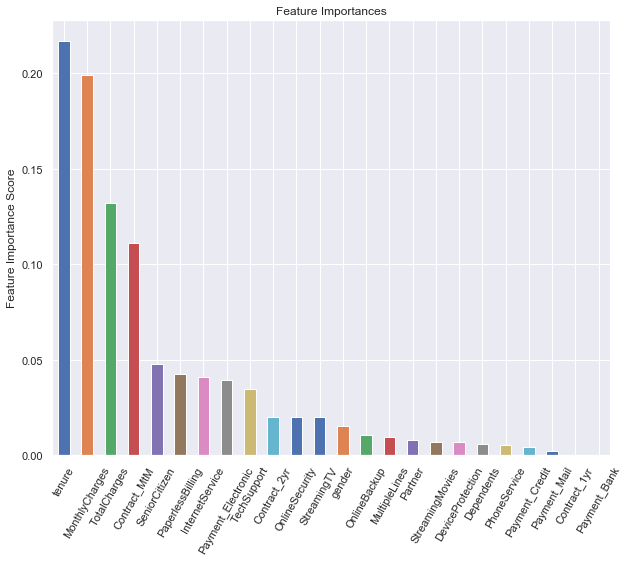

In [69]:
model = GradientBoostingClassifier(
    random_state=42,
    n_estimators=100,
    min_samples_leaf=90,
    max_features=8,
    learning_rate=0.05
)

sgbm_gsearch = grid_classifier(model, test_x, test_y, feat_imp=True)

---
### XGBoost
#### Baseline

Seconds to fit: 0.97
Grid Scores: 

{'mean_fit_time': array([0.33000956]),
 'mean_score_time': array([0.00603452]),
 'mean_test_score': array([0.84780412]),
 'mean_train_score': array([0.92422446]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.86111787]),
 'split0_train_score': array([0.92668789]),
 'split1_test_score': array([0.86630593]),
 'split1_train_score': array([0.91974655]),
 'split2_test_score': array([0.8351237]),
 'split2_train_score': array([0.9215565]),
 'split3_test_score': array([0.82727051]),
 'split3_train_score': array([0.93042132]),
 'split4_test_score': array([0.84911595]),
 'split4_train_score': array([0.92271006]),
 'std_fit_time': array([0.06777338]),
 'std_score_time': array([0.00192128]),
 'std_test_score': array([0.01486311]),
 'std_train_score': array([0.00384533])}
Best Model Parameters: {}
Best Model Score: 0.8478


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

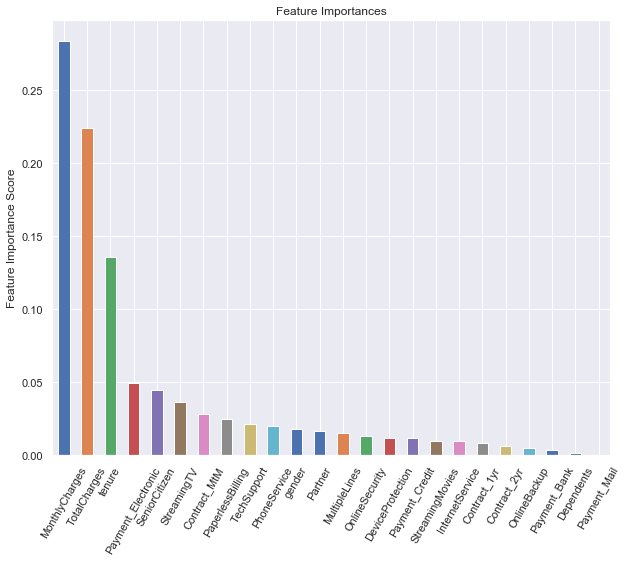

In [71]:
model = XGBClassifier(random_state=42)

grid_classifier(model, test_x, test_y, feat_imp=True)

#### N_estimators

Seconds to fit: 18.32
Grid Scores: 

{'mean_fit_time': array([0.11810703, 0.16228189, 0.23952556, 0.39508996, 0.39819093,
       0.38685288, 0.45254474, 0.50824556, 0.7258328 , 0.99202075,
       0.97036376, 0.80341306, 0.779845  , 0.89896941, 0.952806  ,
       0.90689259, 1.0190681 , 1.42355294, 1.09162903]),
 'mean_score_time': array([0.00605698, 0.00537372, 0.00473399, 0.00989146, 0.00409074,
       0.00694442, 0.00392489, 0.01007891, 0.01049647, 0.00856695,
       0.00653315, 0.00653977, 0.00659294, 0.01241355, 0.0079349 ,
       0.00789838, 0.00777278, 0.01168728, 0.00842276]),
 'mean_test_score': array([0.83337611, 0.83729262, 0.83914353, 0.84029649, 0.84203548,
       0.84347032, 0.84351836, 0.84416163, 0.844267  , 0.84423375,
       0.84433588, 0.84407758, 0.84394541, 0.84363485, 0.84336359,
       0.84297494, 0.8426616 , 0.84262602, 0.84244948]),
 'mean_train_score': array([0.83963509, 0.84510755, 0.84871658, 0.85157033, 0.85487376,
       0.85764913, 0.85979565, 0.86172572, 

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': range(10, 101, 5)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

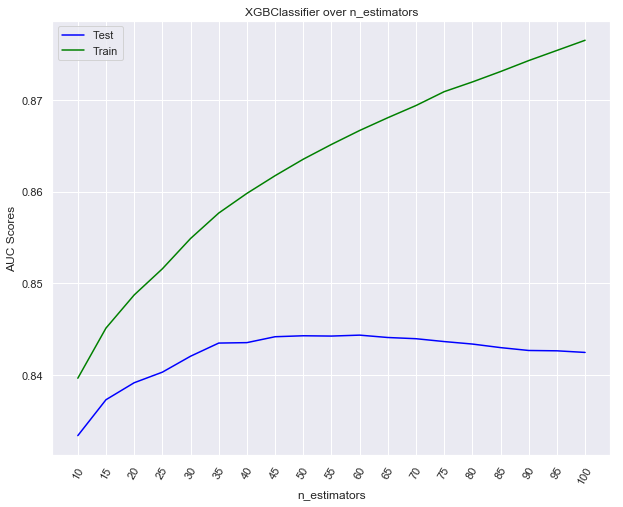

In [72]:
model = XGBClassifier(random_state=42)

parameters = {'n_estimators': range(10, 101, 5)}

grid_classifier(model, train_x, train_y, parameters)

#### Max Depth
Sticking with default value of 3

Seconds to fit: 15.52
Grid Scores: 

{'mean_fit_time': array([0.70953979, 0.93964262, 0.87059155, 1.03144107, 1.19965525,
       1.35878201, 1.49884024, 1.64315715, 1.80539346]),
 'mean_score_time': array([0.00804758, 0.00794587, 0.00723658, 0.00794711, 0.00954242,
       0.01177945, 0.00974388, 0.01159639, 0.01844211]),
 'mean_test_score': array([0.84433588, 0.84241763, 0.83994528, 0.83792588, 0.83254471,
       0.82990202, 0.82596315, 0.82462132, 0.82280997]),
 'mean_train_score': array([0.86665536, 0.88356639, 0.9049255 , 0.93057918, 0.95260681,
       0.97163205, 0.98449153, 0.99135938, 0.99522178]),
 'param_max_depth': masked_array(data=[3, 4, 5, 6, 7, 8, 9, 10, 11],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object),
 'params': [{'max_depth': 3},
            {'max_depth': 4},
            {'max_depth': 5},
            {'max_depth': 6},
            {'max_depth': 7},
            {'max

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=60,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(3, 12)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='roc_auc', verbose=0)

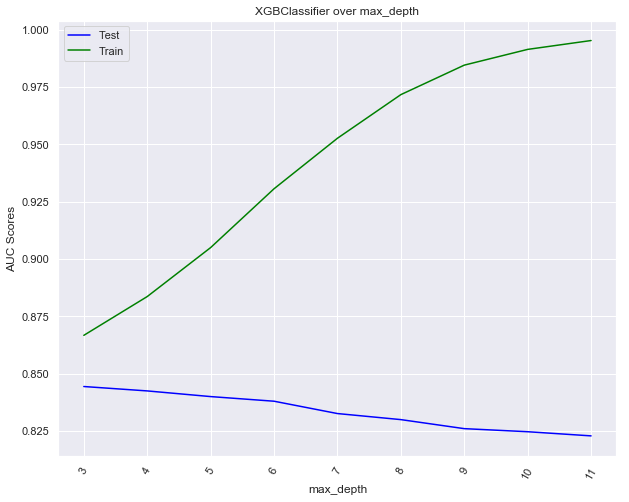

In [73]:
model = XGBClassifier(
    random_state=42,
    n_estimators=60
)
    
parameters = {'max_depth': range(3, 12)}

grid_classifier(model, train_x, train_y, parameters)

#### Min Child Weight

Seconds to fit: 18.34
Grid Scores: 

{'mean_fit_time': array([0.6470448 , 0.65115829, 0.66195049, 0.63415575, 0.68333054,
       0.71354766, 0.62216001, 0.62262511, 0.61300998, 0.61204181,
       0.60598269, 0.61583543, 0.60544457, 0.6076304 , 0.62825289,
       0.6789289 , 0.83750954, 1.05699005, 0.69272704, 0.57840953]),
 'mean_score_time': array([0.00993519, 0.00808001, 0.0065187 , 0.00570822, 0.00777159,
       0.00535927, 0.00626035, 0.00600991, 0.00569921, 0.00569425,
       0.00647969, 0.00548363, 0.00649962, 0.00574312, 0.006742  ,
       0.01014204, 0.01579452, 0.01622148, 0.00542593, 0.00507722]),
 'mean_test_score': array([0.84433588, 0.84445921, 0.84398789, 0.84470876, 0.84479249,
       0.84442925, 0.84486411, 0.84465562, 0.84454294, 0.84520462,
       0.844713  , 0.8452606 , 0.84505961, 0.84531195, 0.84572228,
       0.8456535 , 0.84524954, 0.84582446, 0.8452713 , 0.84494537]),
 'mean_train_score': array([0.86665536, 0.86628846, 0.86581257, 0.86593124, 0.86576415,
       

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=60,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'min_child_weight': range(1, 21)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

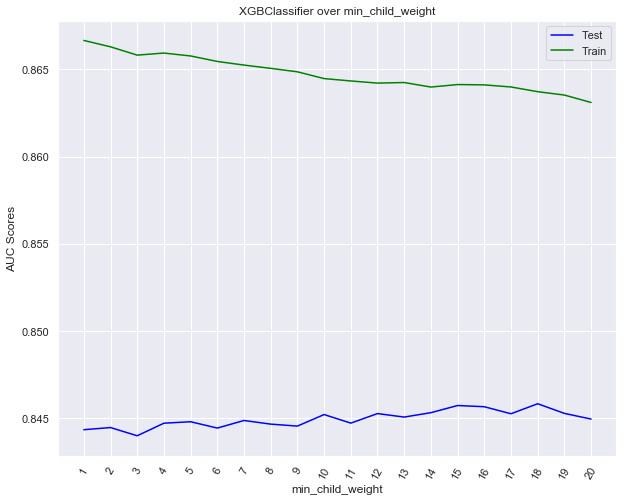

In [76]:
model = XGBClassifier(
    random_state=42,
    n_estimators=60
)
    
parameters = {'min_child_weight': range(1, 21)}

grid_classifier(model, train_x, train_y, parameters)

#### Subsample
Keeping this the same

Seconds to fit: 9.95
Grid Scores: 

{'mean_fit_time': array([0.63639765, 0.64059677, 0.60599761, 0.61284466, 0.61840067,
       0.67932167, 0.68285751, 0.63799205, 0.63171053, 0.69358144,
       0.58643775]),
 'mean_score_time': array([0.00883536, 0.00584855, 0.00585899, 0.00783758, 0.00714707,
       0.00695024, 0.00652518, 0.00602055, 0.00731244, 0.00777435,
       0.00478196]),
 'mean_test_score': array([0.84456521, 0.84421581, 0.84439451, 0.84425702, 0.84499907,
       0.84508622, 0.84496378, 0.84512894, 0.84522825, 0.84485807,
       0.84582446]),
 'mean_train_score': array([0.86003531, 0.86075775, 0.86131812, 0.86168998, 0.86185844,
       0.86243859, 0.86228956, 0.86302821, 0.86355644, 0.86379739,
       0.86371607]),
 'param_subsample': masked_array(data=[0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8,
                   0.8500000000000001, 0.9, 0.95, 1.0],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False],
       fill_valu

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=18, missing=None, n_estimators=60,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'subsample': array([0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

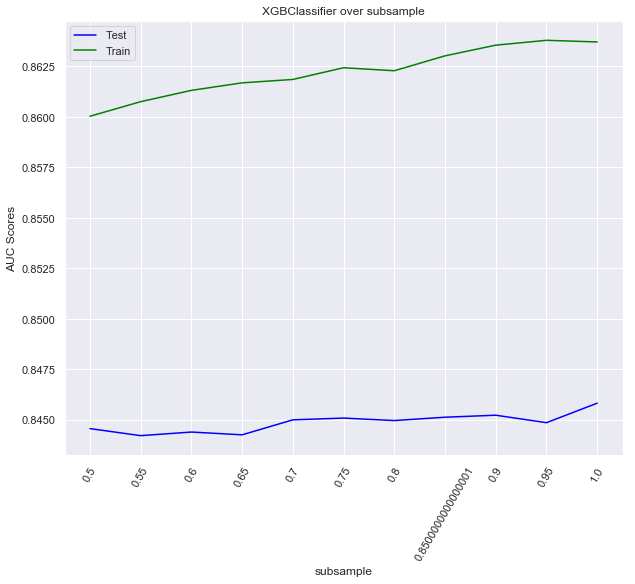

In [77]:
model = XGBClassifier(
    random_state=42,
    n_estimators=60,
    min_child_weight=18,
)
    
parameters = {'subsample': np.linspace(0.5, 1.0, 11)}

grid_classifier(model, train_x, train_y, parameters)

#### Col Sample By Tree
Keeping this the same

Seconds to fit: 10.68
Grid Scores: 

{'mean_fit_time': array([0.43880844, 0.58563704, 0.6303462 , 0.50057182, 0.53933811,
       0.52940321, 0.56494384, 0.6210804 , 0.70098023, 0.6234458 ,
       0.59778819, 0.61445827, 0.56156015]),
 'mean_score_time': array([0.01135492, 0.00705538, 0.00728307, 0.00808544, 0.00702782,
       0.00597978, 0.00612621, 0.00730095, 0.00608621, 0.00559802,
       0.00593843, 0.0053463 , 0.00457983]),
 'mean_test_score': array([0.84519768, 0.84465973, 0.84515333, 0.8451312 , 0.84486969,
       0.84483964, 0.84473764, 0.84581234, 0.84514828, 0.84538497,
       0.84521479, 0.84517604, 0.84582446]),
 'mean_train_score': array([0.85957191, 0.86100525, 0.8613972 , 0.86219241, 0.86223662,
       0.86309603, 0.86320647, 0.86361603, 0.86361737, 0.86407177,
       0.86374994, 0.8636586 , 0.86371607]),
 'param_colsample_bytree': masked_array(data=[0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85,
                   0.8999999999999999, 0.95, 1.0],
             mas

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=18, missing=None, n_estimators=60,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'colsample_bytree': array([0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 ,
       0.95, 1.  ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

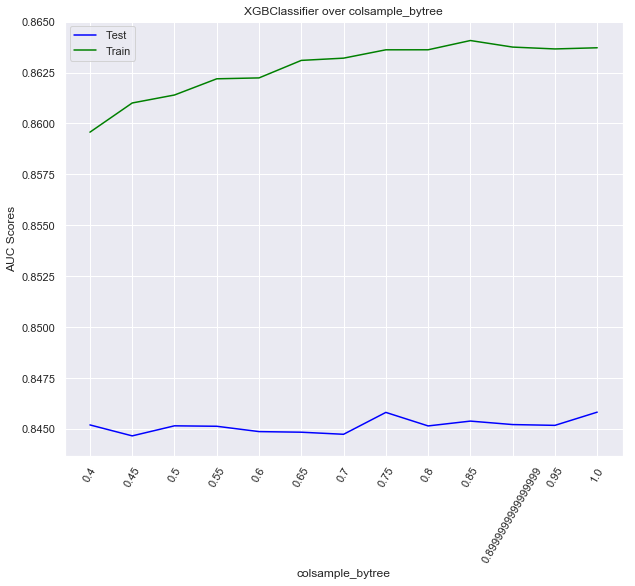

In [78]:
model = XGBClassifier(
    random_state=42,
    n_estimators=60,
    min_child_weight=18
)
    
parameters = {'colsample_bytree': np.linspace(0.4, 1.0, 13)}

grid_classifier(model, train_x, train_y, parameters)

#### Scale Pos Weight

Seconds to fit: 17.76
Grid Scores: 

{'mean_fit_time': array([0.3646728 , 0.61509285, 0.64046979, 0.58316255, 0.60338845,
       0.62599583, 0.61398597, 0.62533107, 0.60771136, 0.64588251,
       0.65840335, 0.67669439, 0.67484164, 0.62306356, 0.64572859,
       0.64305825, 0.64351058, 0.67000742, 0.62848654, 0.63527322,
       0.56561527]),
 'mean_score_time': array([0.00668702, 0.00611644, 0.00512357, 0.00538425, 0.00598574,
       0.00539403, 0.00528789, 0.00540991, 0.00491786, 0.00710759,
       0.00688643, 0.00669622, 0.00546932, 0.00632186, 0.00794406,
       0.00592275, 0.00749121, 0.00633063, 0.00562429, 0.00513983,
       0.00676022]),
 'mean_test_score': array([0.5       , 0.826413  , 0.83971368, 0.84348278, 0.84424805,
       0.84432386, 0.84453274, 0.84485115, 0.84467971, 0.84472266,
       0.84472399, 0.84445928, 0.84524857, 0.8449935 , 0.84509703,
       0.844999  , 0.84479204, 0.84517145, 0.8451964 , 0.84582534,
       0.84582446]),
 'mean_train_score': array([0.5       

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=18, missing=None, n_estimators=60,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'scale_pos_weight': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

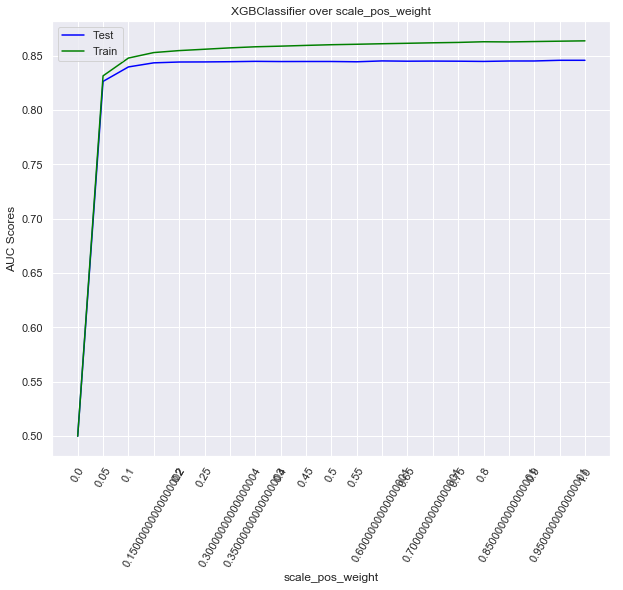

In [79]:
model = XGBClassifier(
    random_state=42,
    n_estimators=60,
    min_child_weight=18,
)
    
parameters = {'scale_pos_weight': np.arange(0.0, 1.01, 0.05)}

grid_classifier(model, train_x, train_y, parameters)

#### Learning Rate
Increase and decrease the learning rate in proportion to the trees. 

Results:

| factor | trees | rate  | AUC    |
|--------|-------|-------|--------|
| 2/3    | 40    | 0.15  | 0.8448 |
| 1      | 60    | 0.1   | 0.8458 |
| 1.5    | 90    | 0.067 | 0.8453 |
| 2      | 120   | 0.05  | 0.8449 |
| 4      | 240   | 0.025 | 0.8453 |

Sticking with initial value of learning rate and trees

In [80]:
model = XGBClassifier(
    random_state=42,
    n_estimators=40,
    min_child_weight=18,
    learning_rate=0.15
)

grid_classifier(model, train_x, train_y)

Seconds to fit: 1.21
Grid Scores: 

{'mean_fit_time': array([0.40922246]),
 'mean_score_time': array([0.01086612]),
 'mean_test_score': array([0.84481694]),
 'mean_train_score': array([0.86371953]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.86355178]),
 'split0_train_score': array([0.85956967]),
 'split1_test_score': array([0.84448103]),
 'split1_train_score': array([0.86417252]),
 'split2_test_score': array([0.83370707]),
 'split2_train_score': array([0.86577617]),
 'split3_test_score': array([0.83698517]),
 'split3_train_score': array([0.86440761]),
 'split4_test_score': array([0.84534224]),
 'split4_train_score': array([0.8646717]),
 'std_fit_time': array([0.08385455]),
 'std_score_time': array([0.00542547]),
 'std_test_score': array([0.01035643]),
 'std_train_score': array([0.00214646])}
Best Model Parameters: {}
Best Model Score: 0.8448


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.15, max_delta_step=0,
       max_depth=3, min_child_weight=18, missing=None, n_estimators=40,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [81]:
model = XGBClassifier(
    random_state=42,
    n_estimators=60,
    min_child_weight=18,
    learning_rate=0.1
)

grid_classifier(model, train_x, train_y)

Seconds to fit: 1.68
Grid Scores: 

{'mean_fit_time': array([0.59222555]),
 'mean_score_time': array([0.0084785]),
 'mean_test_score': array([0.84582446]),
 'mean_train_score': array([0.86371607]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.86399045]),
 'split0_train_score': array([0.85943982]),
 'split1_test_score': array([0.84450181]),
 'split1_train_score': array([0.86478119]),
 'split2_test_score': array([0.83536461]),
 'split2_train_score': array([0.86521895]),
 'split3_test_score': array([0.83810638]),
 'split3_train_score': array([0.86504799]),
 'split4_test_score': array([0.84714311]),
 'split4_train_score': array([0.8640924]),
 'std_fit_time': array([0.11267376]),
 'std_score_time': array([0.00242069]),
 'std_test_score': array([0.01002589]),
 'std_train_score': array([0.00217233])}
Best Model Parameters: {}
Best Model Score: 0.8458


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=18, missing=None, n_estimators=60,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [82]:
model = XGBClassifier(
    random_state=42,
    n_estimators=90,
    min_child_weight=18,
    learning_rate=0.067
)

grid_classifier(model, train_x, train_y)

Seconds to fit: 2.48
Grid Scores: 

{'mean_fit_time': array([0.94247961]),
 'mean_score_time': array([0.00921836]),
 'mean_test_score': array([0.84529201]),
 'mean_train_score': array([0.86397406]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.86483547]),
 'split0_train_score': array([0.85941454]),
 'split1_test_score': array([0.84401234]),
 'split1_train_score': array([0.86504075]),
 'split2_test_score': array([0.83377411]),
 'split2_train_score': array([0.86589413]),
 'split3_test_score': array([0.83737123]),
 'split3_train_score': array([0.86496785]),
 'split4_test_score': array([0.84644958]),
 'split4_train_score': array([0.86455301]),
 'std_fit_time': array([0.19429998]),
 'std_score_time': array([0.00262232]),
 'std_test_score': array([0.01077468]),
 'std_train_score': array([0.00232106])}
Best Model Parameters: {}
Best Model Score: 0.8453


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.067, max_delta_step=0,
       max_depth=3, min_child_weight=18, missing=None, n_estimators=90,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [83]:
model = XGBClassifier(
    random_state=42,
    n_estimators=120,
    min_child_weight=18,
    learning_rate=0.05
)

grid_classifier(model, train_x, train_y)

Seconds to fit: 3.09
Grid Scores: 

{'mean_fit_time': array([1.21051846]),
 'mean_score_time': array([0.00911179]),
 'mean_test_score': array([0.84492696]),
 'mean_train_score': array([0.86361873]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.86444298]),
 'split0_train_score': array([0.85937699]),
 'split1_test_score': array([0.84321118]),
 'split1_train_score': array([0.86415273]),
 'split2_test_score': array([0.83301816]),
 'split2_train_score': array([0.86582353]),
 'split3_test_score': array([0.83719092]),
 'split3_train_score': array([0.86446031]),
 'split4_test_score': array([0.84675473]),
 'split4_train_score': array([0.86428011]),
 'std_fit_time': array([0.24773008]),
 'std_score_time': array([0.00142991]),
 'std_test_score': array([0.01085326]),
 'std_train_score': array([0.00220383])}
Best Model Parameters: {}
Best Model Score: 0.8449


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=18, missing=None, n_estimators=120,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [84]:
model = XGBClassifier(
    random_state=42,
    n_estimators=240,
    min_child_weight=18,
    learning_rate=0.025
)

grid_classifier(model, train_x, train_y)

Seconds to fit: 5.64
Grid Scores: 

{'mean_fit_time': array([2.24220028]),
 'mean_score_time': array([0.01514192]),
 'mean_test_score': array([0.84534426]),
 'mean_train_score': array([0.86370049]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.86475697]),
 'split0_train_score': array([0.85941483]),
 'split1_test_score': array([0.84373066]),
 'split1_train_score': array([0.86466232]),
 'split2_test_score': array([0.83388045]),
 'split2_train_score': array([0.86541908]),
 'split3_test_score': array([0.83769719]),
 'split3_train_score': array([0.86482043]),
 'split4_test_score': array([0.84663914]),
 'split4_train_score': array([0.86418582]),
 'std_fit_time': array([0.47348211]),
 'std_score_time': array([0.00457251]),
 'std_test_score': array([0.01068806]),
 'std_train_score': array([0.00217878])}
Best Model Parameters: {}
Best Model Score: 0.8453


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.025, max_delta_step=0,
       max_depth=3, min_child_weight=18, missing=None, n_estimators=240,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

#### Final XGBoost Model

Seconds to fit: 0.67
Grid Scores: 

{'mean_fit_time': array([0.20167317]),
 'mean_score_time': array([0.00461969]),
 'mean_test_score': array([0.85438751]),
 'mean_train_score': array([0.88911166]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.86612354]),
 'split0_train_score': array([0.88862765]),
 'split1_test_score': array([0.859375]),
 'split1_train_score': array([0.88690696]),
 'split2_test_score': array([0.83664958]),
 'split2_train_score': array([0.89268319]),
 'split3_test_score': array([0.85056559]),
 'split3_train_score': array([0.8910596]),
 'split4_test_score': array([0.85918997]),
 'split4_train_score': array([0.88628091]),
 'std_fit_time': array([0.04190854]),
 'std_score_time': array([0.00139407]),
 'std_test_score': array([0.01014907]),
 'std_train_score': array([0.0024355])}
Best Model Parameters: {}
Best Model Score: 0.8544


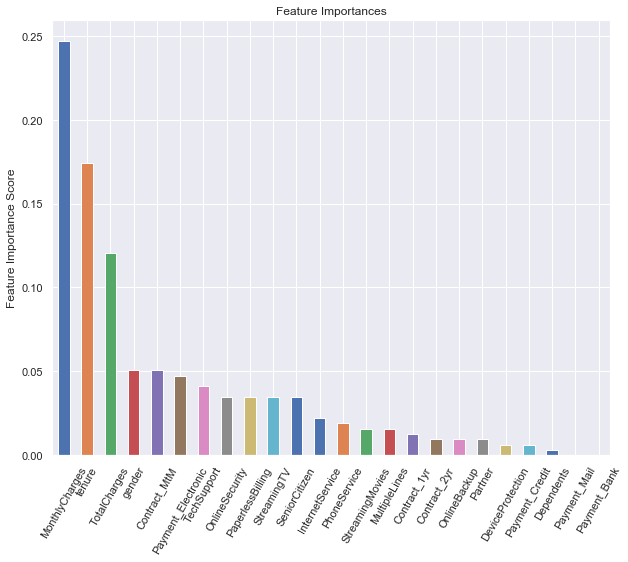

In [87]:
model = XGBClassifier(
    random_state=42,
    n_estimators=60,
    min_child_weight=18,
    learning_rate=0.1
)

xgb_gsearch = grid_classifier(model, test_x, test_y, feat_imp=True)

---
### LightGBM
#### Baseline

In [148]:
# These are all the categorical columns, all of which are one hot encoded
cat_cols = full_train.nunique()[full_train.nunique()==2].index.tolist()
# lightGBM wants ints, not strings, it's finicky like that
cat_cols = [full_train.columns.get_loc(col) for col in cat_cols]

# I have this here for a weird reason. Here's where my trail ended..
# If you pass categorical columns to lightGBM is tosses up a UserWarning, so far what I've found is:
# https://stackoverflow.com/questions/50686645/grid-search-with-lightgbm-example
# Seems to be something funky with GridSearchCV as well, supposedly passing the parameters
# to GridSearchCV.fit(x, y, fit_params=parameters) is supposed to work but despite the documentation
# GridSearchCV does not recognize that argument in it's .fit() attribute. I tried "params", "fit_params",
# and just sticking the dictionary in there raw with no argument label. No dice! 
# Ok, so why am I typing all this? Because it actually works! Despite the warnings.
# the AUC goes up an astounding 0.001 with categorical features specified. 
# The next two blocks demonstrate this.
# So keep this if you want, I found the warning messages really annoying.
import warnings
warnings.filterwarnings('ignore')

Seconds to fit: 2.59
Grid Scores: 

{'mean_fit_time': array([1.50022607]),
 'mean_score_time': array([0.01471338]),
 'mean_test_score': array([0.82838388]),
 'mean_train_score': array([0.99746937]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.85023508]),
 'split0_train_score': array([0.99807298]),
 'split1_test_score': array([0.83835927]),
 'split1_train_score': array([0.99708336]),
 'split2_test_score': array([0.82954915]),
 'split2_train_score': array([0.99743357]),
 'split3_test_score': array([0.7946167]),
 'split3_train_score': array([0.99737885]),
 'split4_test_score': array([0.82907072]),
 'split4_train_score': array([0.99737807]),
 'std_fit_time': array([0.46574217]),
 'std_score_time': array([0.00211568]),
 'std_test_score': array([0.0185456]),
 'std_train_score': array([0.00032593])}
Best Model Parameters: {}
Best Model Score: 0.8284


GridSearchCV(cv=5, error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

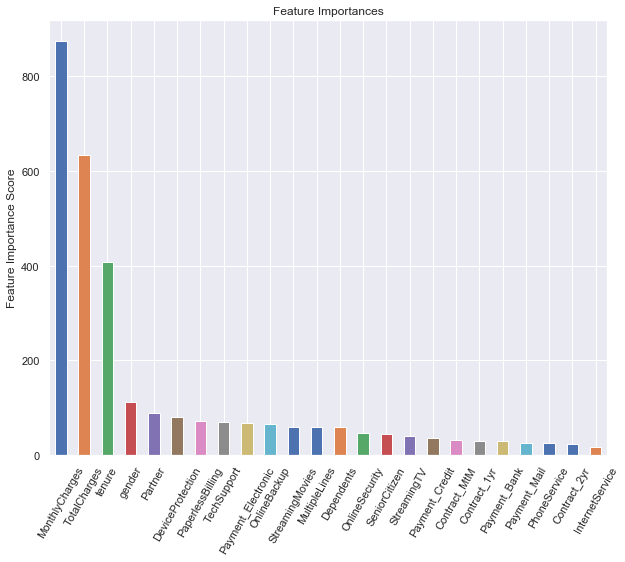

In [146]:
model = LGBMClassifier(random_state=42)

grid_classifier(model, test_x, test_y, feat_imp=True)

Seconds to fit: 2.47
Grid Scores: 

{'mean_fit_time': array([1.48153396]),
 'mean_score_time': array([0.02074614]),
 'mean_test_score': array([0.82845764]),
 'mean_train_score': array([0.99732672]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.85023508]),
 'split0_train_score': array([0.99807298]),
 'split1_test_score': array([0.83835927]),
 'split1_train_score': array([0.99708336]),
 'split2_test_score': array([0.82954915]),
 'split2_train_score': array([0.99743357]),
 'split3_test_score': array([0.7946167]),
 'split3_train_score': array([0.99737885]),
 'split4_test_score': array([0.82944079]),
 'split4_train_score': array([0.99666484]),
 'std_fit_time': array([0.51091195]),
 'std_score_time': array([0.01250134]),
 'std_test_score': array([0.01854892]),
 'std_train_score': array([0.00046224])}
Best Model Parameters: {}
Best Model Score: 0.8285


GridSearchCV(cv=5, error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt',
        categorical_feature=[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22, 23],
        class_weight=None, colsample_bytree=1.0, importance_type='split',
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min...0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

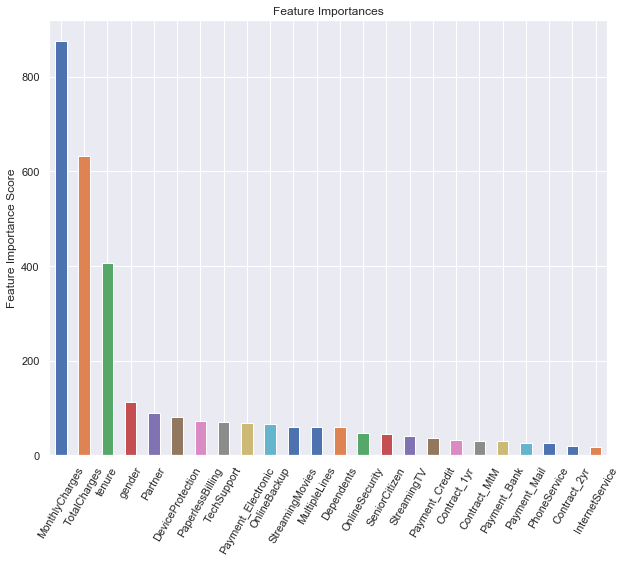

In [144]:
model = LGBMClassifier(
    random_state=42,
    categorical_feature=cat_cols
)

grid_classifier(model, test_x, test_y, feat_imp=True)

#### Max Depth
I can't in good faith set the depth to 2. That's 4 leaves. Need something a little bushier.

I'll go three routes to see what's going on. The depths will be 2, 3, and 5. I betting on 5.

Once I've determined the best of those three I'll tune the learning rate.

Seconds to fit: 50.07
Grid Scores: 

{'mean_fit_time': array([0.346387  , 0.50800633, 0.838271  , 1.50680842, 1.84995346,
       2.10312381, 2.31089978, 2.75728769, 2.14935436, 2.21787887,
       2.33973355, 2.44080338, 2.64227023, 2.34213457, 2.27425137,
       2.12732959, 2.46599178, 2.65026364, 2.07218437]),
 'mean_score_time': array([0.01837602, 0.0162066 , 0.01862926, 0.02539606, 0.02095098,
       0.02343655, 0.028933  , 0.024403  , 0.01946568, 0.02388401,
       0.0192369 , 0.02453361, 0.0269906 , 0.01996059, 0.02238765,
       0.02647777, 0.0223278 , 0.02390718, 0.02582679]),
 'mean_test_score': array([0.84435286, 0.84235028, 0.83726093, 0.83398152, 0.83153034,
       0.82856116, 0.82803683, 0.8280792 , 0.82647532, 0.82751499,
       0.82766327, 0.82742086, 0.82587076, 0.82529728, 0.82543211,
       0.8242807 , 0.82479033, 0.82485279, 0.82501085]),
 'mean_train_score': array([0.86028599, 0.87711617, 0.90071782, 0.92445462, 0.9388038 ,
       0.94867037, 0.95448551, 0.95743468, 

GridSearchCV(cv=5, error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt',
        categorical_feature=[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22, 23],
        class_weight=None, colsample_bytree=1.0, importance_type='split',
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min...0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(2, 21)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='roc_auc', verbose=0)

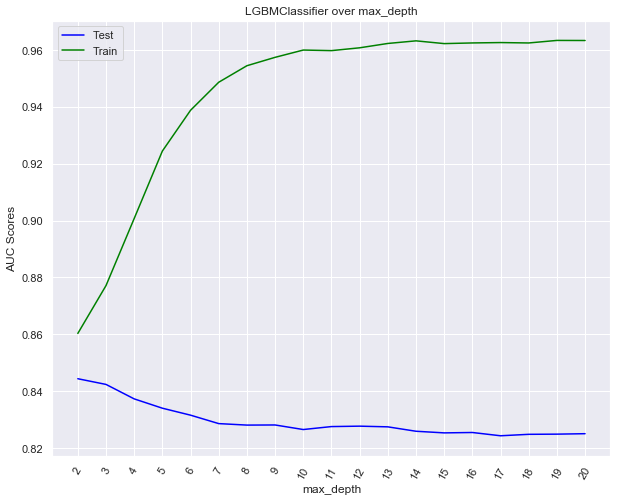

In [152]:
model = LGBMClassifier(
    random_state=42,
    categorical_feature=cat_cols
)

parameters = {'max_depth': range(2, 21)}

grid_classifier(model, train_x, train_y, parameters)

#### Min Data In Leaf (Depth=2)

Seconds to fit: 21.77
Grid Scores: 

{'mean_fit_time': array([0.34184828, 0.5696651 , 0.50455089, 0.35979428, 0.38644609,
       0.34481201, 0.30646377, 0.3237957 , 0.32669206, 0.31473579,
       0.33208499, 0.31892118, 0.32749958, 0.32943683, 0.31631827,
       0.3704236 , 0.46326923, 0.57764044, 0.48456259, 0.4557446 ,
       0.34841256, 0.53465319, 0.62492981, 0.67747359, 0.55058417,
       0.43272696, 0.39955921, 0.3432765 , 0.34212799, 0.34305182,
       0.34071436, 0.39221783, 0.66853538, 0.5376266 , 0.42739859,
       0.35928917]),
 'mean_score_time': array([0.01613355, 0.02048249, 0.02201734, 0.01904478, 0.01572113,
       0.01625738, 0.01678433, 0.01648817, 0.01713896, 0.01461177,
       0.01595201, 0.0160809 , 0.01494241, 0.01591487, 0.01812878,
       0.01462822, 0.01758442, 0.01871972, 0.0164299 , 0.02028461,
       0.01883845, 0.02117324, 0.02346821, 0.02192903, 0.01874561,
       0.02238121, 0.01611018, 0.01761904, 0.01424417, 0.01484261,
       0.01882873, 0.024717  , 0.

GridSearchCV(cv=5, error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt',
        categorical_feature=[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22, 23],
        class_weight=None, colsample_bytree=1.0, importance_type='split',
        learning_rate=0.1, max_depth=2, min_child_samples=20,
        min_...0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'min_data_in_leaf': range(25, 201, 5)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

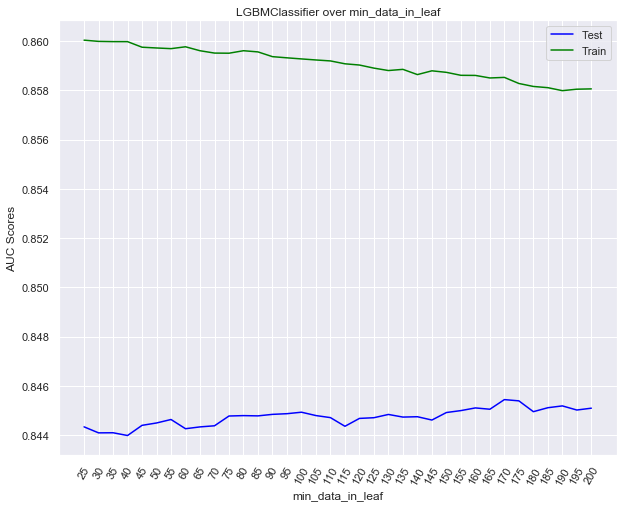

In [157]:
model = LGBMClassifier(
    random_state=42,
    categorical_feature=cat_cols,
    max_depth=2,
)

parameters = {'min_data_in_leaf': range(25, 201, 5)}

grid_classifier(model, train_x, train_y, parameters)

#### Num Leaves (Depth=2)
Looks like max_depth is preventing this from overfitting now. I'll stick with default of 31.
Not that it matters since that's greater than 2^max_depth

Seconds to fit: 4.19
Grid Scores: 

{'mean_fit_time': array([0.32709551, 0.33993163, 0.35607333, 0.4685174 , 0.31733766,
       0.32737298, 0.2744545 , 0.27117023]),
 'mean_score_time': array([0.01563592, 0.01946001, 0.01663213, 0.01627254, 0.01614814,
       0.01446223, 0.01728644, 0.01499987]),
 'mean_test_score': array([0.84544124, 0.84544124, 0.84544124, 0.84544124, 0.84544124,
       0.84544124, 0.84544124, 0.84544124]),
 'mean_train_score': array([0.85853018, 0.85853018, 0.85853018, 0.85853018, 0.85853018,
       0.85853018, 0.85853018, 0.85853018]),
 'param_num_leaves': masked_array(data=[15, 20, 25, 30, 35, 40, 45, 50],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'num_leaves': 15},
            {'num_leaves': 20},
            {'num_leaves': 25},
            {'num_leaves': 30},
            {'num_leaves': 35},
            {'num_leaves': 40},
            {'num_leaves': 45},
            {'

GridSearchCV(cv=5, error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt',
        categorical_feature=[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22, 23],
        class_weight=None, colsample_bytree=1.0, importance_type='split',
        learning_rate=0.1, max_depth=2, min_child_samples=20,
        min_...0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'num_leaves': range(15, 51, 5)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

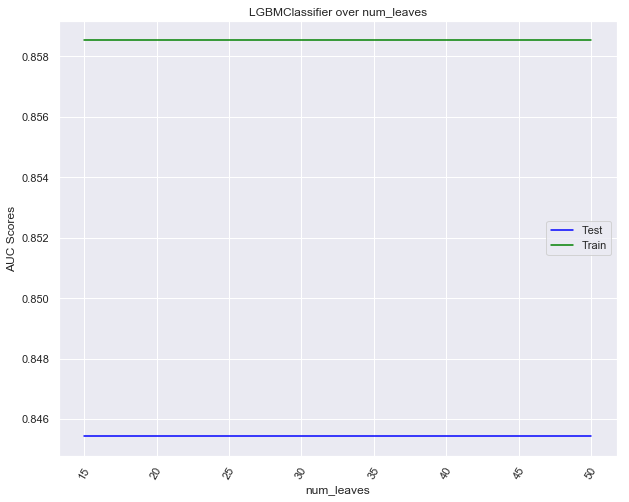

In [158]:
model = LGBMClassifier(
    random_state=42,
    categorical_feature=cat_cols,
    max_depth=2,
    min_data_in_leaf=170
)

parameters = {'num_leaves': range(15, 51, 5)}

grid_classifier(model, train_x, train_y, parameters)

#### N Estimators (Depth=2)

Seconds to fit: 20.78
Grid Scores: 

{'mean_fit_time': array([0.12202187, 0.13813496, 0.13945255, 0.26000118, 0.27739654,
       0.23572874, 0.27346582, 0.20236859, 0.24861083, 0.29783273,
       0.43542604, 0.3727818 , 0.3011764 , 0.3799243 , 0.32429509,
       0.30213685, 0.36913323, 0.37331691, 0.39631476, 0.41679144,
       0.37455955, 0.41316342, 0.40650201, 0.52489486, 0.63133821,
       0.50850692, 0.50737748, 0.57454257, 0.54871221, 0.55597172,
       0.57480378, 0.56558394, 0.6239162 , 0.5763588 , 0.52852635,
       0.53501773]),
 'mean_score_time': array([0.0136713 , 0.01494122, 0.01905355, 0.02757063, 0.01713586,
       0.02100968, 0.01659026, 0.01440678, 0.01460896, 0.01684899,
       0.01800814, 0.01892996, 0.01583018, 0.01529489, 0.0157124 ,
       0.01558933, 0.01331105, 0.01629186, 0.01546235, 0.01373057,
       0.01523933, 0.01507287, 0.01580181, 0.0153338 , 0.01739478,
       0.01653795, 0.01593752, 0.01824341, 0.01883402, 0.02089758,
       0.01875682, 0.01603947, 0.

GridSearchCV(cv=5, error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt',
        categorical_feature=[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22, 23],
        class_weight=None, colsample_bytree=1.0, importance_type='split',
        learning_rate=0.1, max_depth=2, min_child_samples=20,
        min_...0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': range(25, 201, 5)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

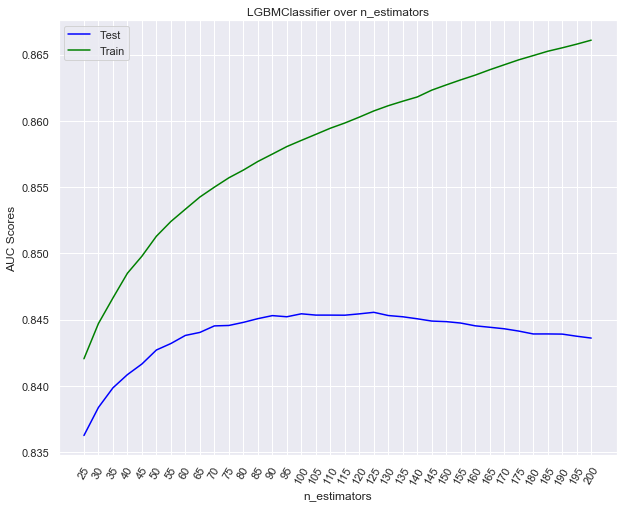

In [159]:
model = LGBMClassifier(
    random_state=42,
    categorical_feature=cat_cols,
    max_depth=2,
    min_data_in_leaf=170
)

parameters = {'n_estimators': range(25, 201, 5)}

grid_classifier(model, train_x, train_y, parameters)

#### Col Sample By Tree (Depth=2)

Seconds to fit: 7.38
Grid Scores: 

{'mean_fit_time': array([0.26035447, 0.24899216, 0.2739799 , 0.2848454 , 0.30280442,
       0.37181544, 0.75094042, 0.68514681, 0.3811183 , 0.32308521,
       0.30765252, 0.31872396, 0.31161356]),
 'mean_score_time': array([0.01831212, 0.01472912, 0.01509495, 0.0149262 , 0.01942353,
       0.0189445 , 0.0207283 , 0.01921644, 0.0139678 , 0.01372762,
       0.01544194, 0.01443114, 0.0146317 ]),
 'mean_test_score': array([0.84436631, 0.8446237 , 0.84496667, 0.84477854, 0.8452578 ,
       0.84529423, 0.84511407, 0.84507991, 0.84528919, 0.84545464,
       0.84528787, 0.84510017, 0.84544124]),
 'mean_train_score': array([0.85618825, 0.85647185, 0.85717608, 0.85762841, 0.85762558,
       0.85784296, 0.85790126, 0.85801896, 0.85803313, 0.85818904,
       0.85834893, 0.85860802, 0.85853018]),
 'param_colsample_bytree': masked_array(data=[0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85,
                   0.8999999999999999, 0.95, 1.0],
             mask

GridSearchCV(cv=5, error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt',
        categorical_feature=[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22, 23],
        class_weight=None, colsample_bytree=1.0, importance_type='split',
        learning_rate=0.1, max_depth=2, min_child_samples=20,
        min_...0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'colsample_bytree': array([0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 ,
       0.95, 1.  ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

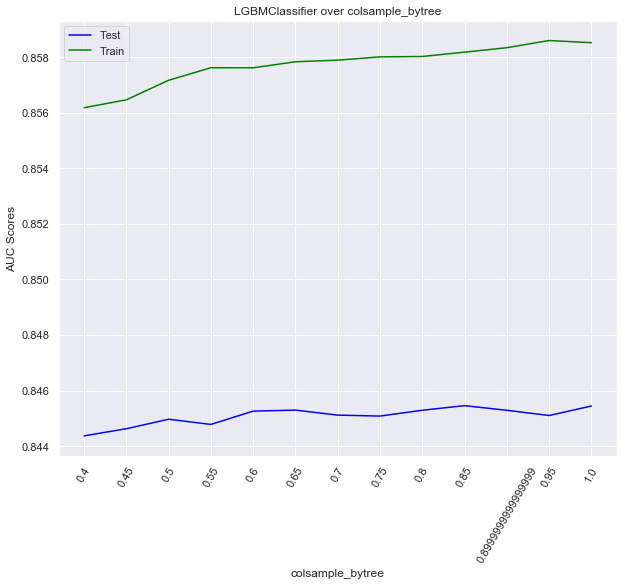

In [160]:
model = LGBMClassifier(
    random_state=42,
    categorical_feature=cat_cols,
    max_depth=2,
    min_data_in_leaf=170,
    n_estimators=100
)

parameters = {'colsample_bytree': np.linspace(0.4, 1.0, 13)}

grid_classifier(model, train_x, train_y, parameters)

#### Final LightGBM Model (Depth=2)

Seconds to fit: 0.65
Grid Scores: 

{'mean_fit_time': array([0.23036118]),
 'mean_score_time': array([0.01263056]),
 'mean_test_score': array([0.85581144]),
 'mean_train_score': array([0.88356544]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.86391456]),
 'split0_train_score': array([0.88331402]),
 'split1_test_score': array([0.86865678]),
 'split1_train_score': array([0.88146087]),
 'split2_test_score': array([0.83717855]),
 'split2_train_score': array([0.88683396]),
 'split3_test_score': array([0.8540446]),
 'split3_train_score': array([0.88476377]),
 'split4_test_score': array([0.85520148]),
 'split4_train_score': array([0.88145458]),
 'std_fit_time': array([0.03707418]),
 'std_score_time': array([0.00148808]),
 'std_test_score': array([0.01078578]),
 'std_train_score': array([0.00205268])}
Best Model Parameters: {}
Best Model Score: 0.8558


GridSearchCV(cv=5, error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt',
        categorical_feature=[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22, 23],
        class_weight=None, colsample_bytree=1.0, importance_type='split',
        learning_rate=0.1, max_depth=2, min_child_samples=20,
        min_...0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

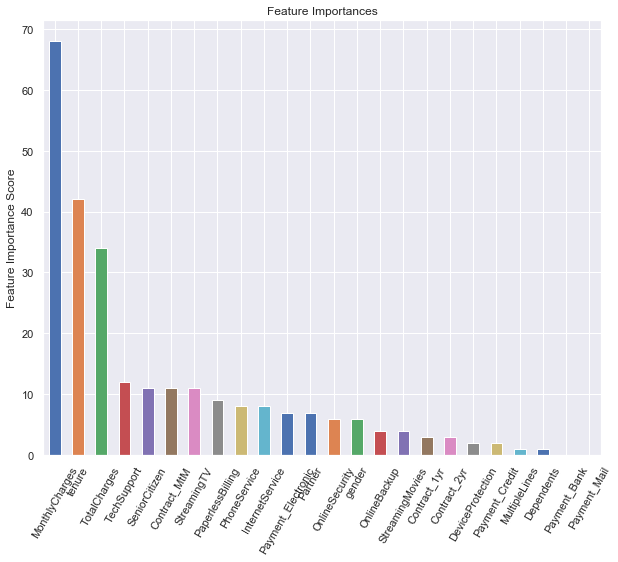

In [161]:
model = LGBMClassifier(
    random_state=42,
    categorical_feature=cat_cols,
    max_depth=2,
    min_data_in_leaf=170,
    n_estimators=100
)

grid_classifier(model, test_x, test_y, feat_imp=True)

#### Min Data In Leaf (Depth=3)

Seconds to fit: 27.78
Grid Scores: 

{'mean_fit_time': array([0.69259591, 0.61797838, 0.52472696, 0.50132594, 0.65715179,
       0.61176581, 0.6434073 , 0.6191257 , 0.58156533, 0.50476675,
       0.50274134, 0.52222142, 0.60159545, 0.54645391, 0.50794501,
       0.57927723, 0.58704176, 0.47143769, 0.53576026, 0.51021762,
       0.535987  , 0.50642905, 0.53830338, 0.4922554 , 0.7218545 ,
       0.55315962, 0.53877678, 0.50829778, 0.52292914, 0.50845647,
       0.48415461, 0.51768208, 0.56100626, 0.52390161, 0.47121687,
       0.49629788]),
 'mean_score_time': array([0.02637691, 0.01904125, 0.01796155, 0.01585159, 0.02067313,
       0.02064309, 0.01954226, 0.01796598, 0.01660919, 0.01622167,
       0.01573105, 0.01694241, 0.02061057, 0.01608047, 0.01609902,
       0.01750903, 0.01841507, 0.01662374, 0.021451  , 0.01575856,
       0.01926861, 0.01770802, 0.02202215, 0.01714802, 0.01744599,
       0.01613593, 0.01658435, 0.01687994, 0.01834402, 0.02006354,
       0.01596079, 0.01694913, 0.

GridSearchCV(cv=5, error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt',
        categorical_feature=[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22, 23],
        class_weight=None, colsample_bytree=1.0, importance_type='split',
        learning_rate=0.1, max_depth=3, min_child_samples=20,
        min_...0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'min_data_in_leaf': range(25, 201, 5)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

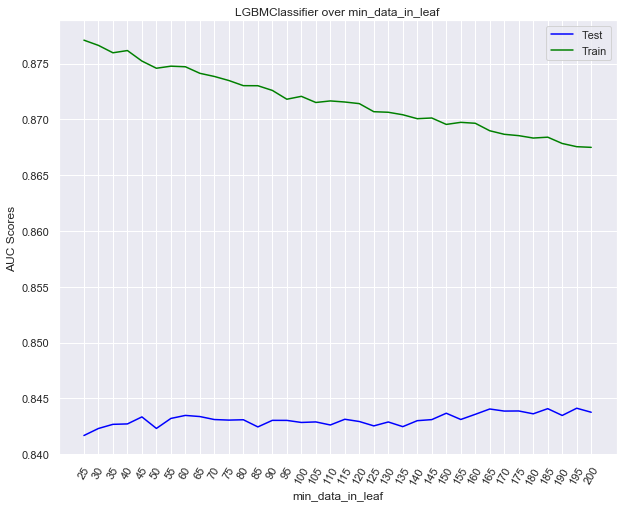

In [162]:
model = LGBMClassifier(
    random_state=42,
    categorical_feature=cat_cols,
    max_depth=3,
)

parameters = {'min_data_in_leaf': range(25, 201, 5)}

grid_classifier(model, train_x, train_y, parameters)

#### Num Leaves (Depth=3)

Seconds to fit: 6.70
Grid Scores: 

{'mean_fit_time': array([0.51474514, 0.64902821, 0.54561682, 0.55148335, 0.51990256,
       0.54382401, 0.52761302, 0.62976661]),
 'mean_score_time': array([0.01956558, 0.01607742, 0.01727033, 0.01875739, 0.02368927,
       0.01704369, 0.01813774, 0.01928654]),
 'mean_test_score': array([0.84235028, 0.84235028, 0.84235028, 0.84235028, 0.84235028,
       0.84235028, 0.84235028, 0.84235028]),
 'mean_train_score': array([0.87711617, 0.87711617, 0.87711617, 0.87711617, 0.87711617,
       0.87711617, 0.87711617, 0.87711617]),
 'param_num_leaves': masked_array(data=[15, 20, 25, 30, 35, 40, 45, 50],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'num_leaves': 15},
            {'num_leaves': 20},
            {'num_leaves': 25},
            {'num_leaves': 30},
            {'num_leaves': 35},
            {'num_leaves': 40},
            {'num_leaves': 45},
            {'

GridSearchCV(cv=5, error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt',
        categorical_feature=[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22, 23],
        class_weight=None, colsample_bytree=1.0, importance_type='split',
        learning_rate=0.1, max_depth=3, min_child_samples=20,
        min_...0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'num_leaves': range(15, 51, 5)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

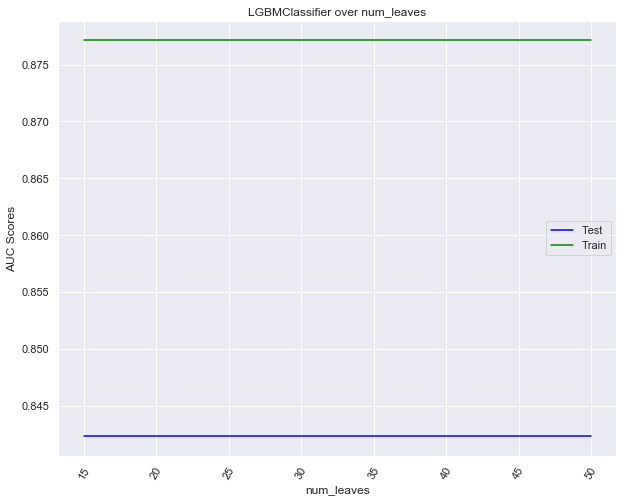

In [164]:
model = LGBMClassifier(
    random_state=42,
    categorical_feature=cat_cols,
    max_depth=3,
    mind_data_in_leaf=165
)

parameters = {'num_leaves': range(15, 51, 5)}

grid_classifier(model, train_x, train_y, parameters)

#### N Estimators (Depth=3)

Seconds to fit: 31.98
Grid Scores: 

{'mean_fit_time': array([0.22935152, 0.26491795, 0.29736423, 0.29024086, 0.3059413 ,
       0.30381169, 0.30153351, 0.3297174 , 0.35960259, 0.3518343 ,
       0.48791275, 0.44149079, 0.44440837, 0.47221155, 0.48528485,
       0.48347154, 0.53837137, 0.54760833, 0.58571835, 0.63441825,
       0.71333346, 0.59648914, 0.63348942, 0.65094399, 0.77463984,
       0.8849257 , 0.83232565, 1.05135593, 0.75971808, 0.8889061 ,
       0.84992867, 1.02966018, 1.54904089, 1.3551074 , 1.12504201,
       1.01358762]),
 'mean_score_time': array([0.01472993, 0.01700802, 0.0131135 , 0.01583858, 0.01354637,
       0.01377711, 0.01571331, 0.01622529, 0.01476121, 0.01523819,
       0.017277  , 0.01623912, 0.0162744 , 0.01602092, 0.01552534,
       0.01672964, 0.0154635 , 0.01634302, 0.01688719, 0.018121  ,
       0.02031546, 0.01712503, 0.01645203, 0.01812811, 0.02221222,
       0.0224226 , 0.02055616, 0.02135596, 0.02168498, 0.02055011,
       0.01781149, 0.02359395, 0.

GridSearchCV(cv=5, error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt',
        categorical_feature=[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22, 23],
        class_weight=None, colsample_bytree=1.0, importance_type='split',
        learning_rate=0.1, max_depth=3, min_child_samples=20,
        min_...0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': range(25, 201, 5)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

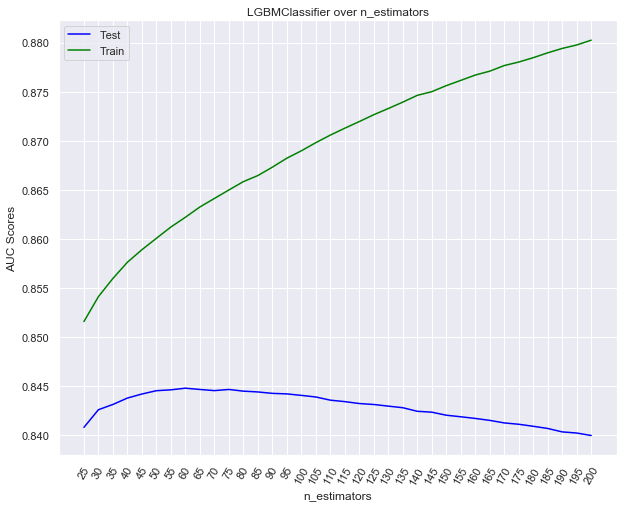

In [165]:
model = LGBMClassifier(
    random_state=42,
    categorical_feature=cat_cols,
    max_depth=3,
    min_data_in_leaf=165
)

parameters = {'n_estimators': range(25, 201, 5)}

grid_classifier(model, train_x, train_y, parameters)

#### Col Sample By Tree (Depth=3)

Seconds to fit: 7.23
Grid Scores: 

{'mean_fit_time': array([0.37048583, 0.46309686, 0.58488803, 0.57454309, 0.33446527,
       0.34497204, 0.31234422, 0.32143254, 0.29988685, 0.31588349,
       0.33085079, 0.2977982 , 0.28356075]),
 'mean_score_time': array([0.01609402, 0.01865859, 0.02672844, 0.0161828 , 0.01646099,
       0.01699309, 0.01659875, 0.0140872 , 0.01380138, 0.01572814,
       0.01403999, 0.0171288 , 0.01517072]),
 'mean_test_score': array([0.84370275, 0.84428588, 0.84473873, 0.84430964, 0.84536817,
       0.84529436, 0.84528238, 0.84506556, 0.84491353, 0.84509832,
       0.84525273, 0.84442506, 0.84478593]),
 'mean_train_score': array([0.85970549, 0.86003557, 0.86109362, 0.86106409, 0.86165362,
       0.8617064 , 0.86176404, 0.86198665, 0.86220058, 0.86251148,
       0.86240967, 0.86246781, 0.86220627]),
 'param_colsample_bytree': masked_array(data=[0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85,
                   0.8999999999999999, 0.95, 1.0],
             mask

GridSearchCV(cv=5, error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt',
        categorical_feature=[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22, 23],
        class_weight=None, colsample_bytree=1.0, importance_type='split',
        learning_rate=0.1, max_depth=3, min_child_samples=20,
        min_...0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'colsample_bytree': array([0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 ,
       0.95, 1.  ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

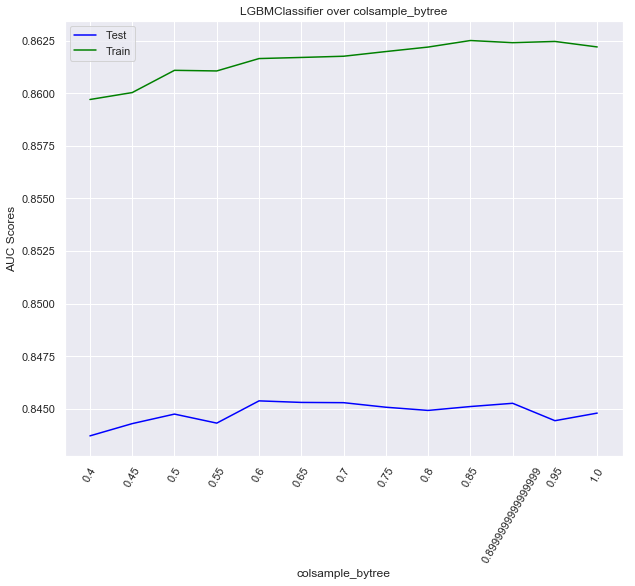

In [166]:
model = LGBMClassifier(
    random_state=42,
    categorical_feature=cat_cols,
    max_depth=3,
    min_data_in_leaf=165,
    n_estimators=60
)

parameters = {'colsample_bytree': np.linspace(0.4, 1.0, 13)}

grid_classifier(model, train_x, train_y, parameters)

#### Final LightGBM Model (Depth=3)

Seconds to fit: 0.68
Grid Scores: 

{'mean_fit_time': array([0.19711142]),
 'mean_score_time': array([0.01312561]),
 'mean_test_score': array([0.85627737]),
 'mean_train_score': array([0.88206393]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.86673152]),
 'split0_train_score': array([0.88229892]),
 'split1_test_score': array([0.86679232]),
 'split1_train_score': array([0.87942813]),
 'split2_test_score': array([0.84124756]),
 'split2_train_score': array([0.88564808]),
 'split3_test_score': array([0.8550415]),
 'split3_train_score': array([0.8829735]),
 'split4_test_score': array([0.85150082]),
 'split4_train_score': array([0.87997101]),
 'std_fit_time': array([0.03605243]),
 'std_score_time': array([0.00191565]),
 'std_test_score': array([0.00969932]),
 'std_train_score': array([0.00223859])}
Best Model Parameters: {}
Best Model Score: 0.8563


GridSearchCV(cv=5, error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt',
        categorical_feature=[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22, 23],
        class_weight=None, colsample_bytree=0.6, importance_type='split',
        learning_rate=0.1, max_depth=3, min_child_samples=20,
        min_...0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

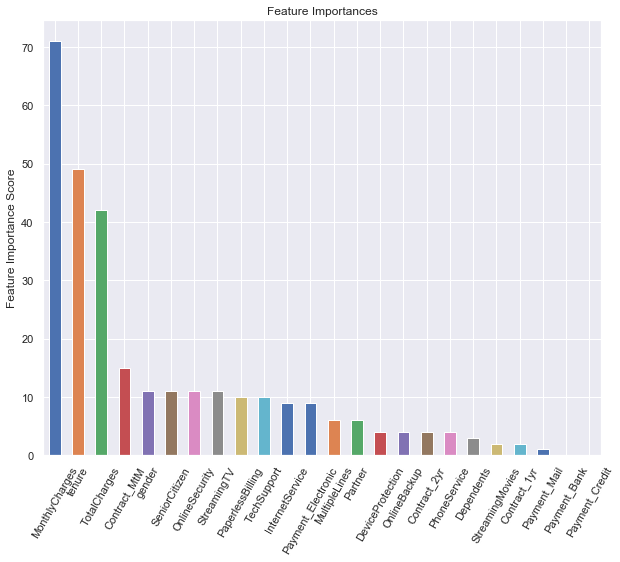

In [168]:
model = LGBMClassifier(
    random_state=42,
    categorical_feature=cat_cols,
    max_depth=3,
    min_data_in_leaf=165,
    n_estimators=60,
    colsample_bytree=0.6
)

grid_classifier(model, test_x, test_y, feat_imp=True)

#### Min Data In Leaf (Depth=5)

Seconds to fit: 47.70
Grid Scores: 

{'mean_fit_time': array([1.38061223, 1.3240212 , 1.18655219, 1.14943585, 1.1494226 ,
       1.09835148, 1.12971053, 1.33573437, 1.13981304, 1.17498426,
       1.03647294, 0.94493008, 1.10980244, 0.98996959, 1.01399059,
       0.91572943, 1.02611423, 1.05460839, 0.95941768, 0.9916234 ,
       1.00586019, 1.01357493, 0.8341114 , 0.80094862, 0.80940447,
       0.85982699, 0.86456499, 0.83287911, 0.77393875, 0.7812417 ,
       0.84482088, 0.82484484, 0.7543231 , 0.8061554 , 0.80107021,
       0.759865  ]),
 'mean_score_time': array([0.02343855, 0.02011442, 0.01829062, 0.01773872, 0.01806302,
       0.01947408, 0.01957788, 0.01979322, 0.02002263, 0.01921473,
       0.01797266, 0.01719666, 0.01891732, 0.01811914, 0.01880407,
       0.01872315, 0.01972165, 0.01714764, 0.01664834, 0.01747212,
       0.01795087, 0.01616673, 0.02313857, 0.0181201 , 0.01735697,
       0.01773658, 0.01977057, 0.01665354, 0.01674271, 0.01716766,
       0.01780667, 0.02225618, 0.

GridSearchCV(cv=5, error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt',
        categorical_feature=[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22, 23],
        class_weight=None, colsample_bytree=1.0, importance_type='split',
        learning_rate=0.1, max_depth=5, min_child_samples=20,
        min_...0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'min_data_in_leaf': range(25, 201, 5)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

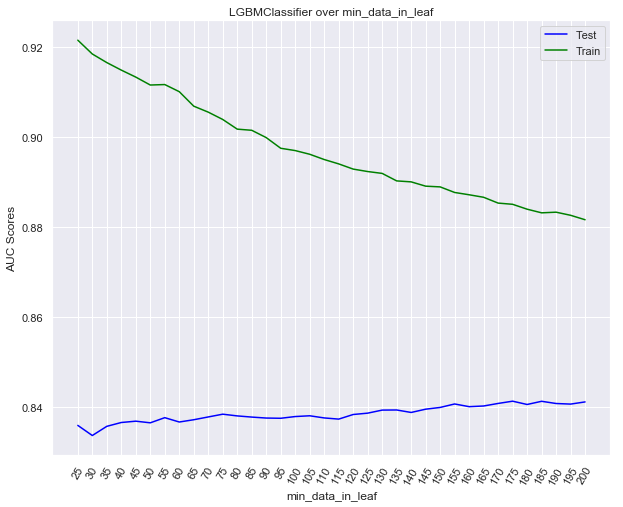

In [169]:
model = LGBMClassifier(
    random_state=42,
    categorical_feature=cat_cols,
    max_depth=5,
)

parameters = {'min_data_in_leaf': range(25, 201, 5)}

grid_classifier(model, train_x, train_y, parameters)

#### Num Leaves (Depth=5)

Seconds to fit: 11.16
Grid Scores: 

{'mean_fit_time': array([1.0021924 , 1.45648961, 0.99615746, 0.83467507, 0.92887359,
       1.10129976, 0.95467448, 0.78804536]),
 'mean_score_time': array([0.02623062, 0.0245225 , 0.02069244, 0.01775336, 0.01738281,
       0.01695132, 0.01708994, 0.01748629]),
 'mean_test_score': array([0.83990875, 0.84126321, 0.84126321, 0.84126321, 0.84126321,
       0.84126321, 0.84126321, 0.84126321]),
 'mean_train_score': array([0.88524842, 0.88505301, 0.88505301, 0.88505301, 0.88505301,
       0.88505301, 0.88505301, 0.88505301]),
 'param_num_leaves': masked_array(data=[15, 20, 25, 30, 35, 40, 45, 50],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'num_leaves': 15},
            {'num_leaves': 20},
            {'num_leaves': 25},
            {'num_leaves': 30},
            {'num_leaves': 35},
            {'num_leaves': 40},
            {'num_leaves': 45},
            {

GridSearchCV(cv=5, error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt',
        categorical_feature=[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22, 23],
        class_weight=None, colsample_bytree=1.0, importance_type='split',
        learning_rate=0.1, max_depth=5, min_child_samples=20,
        min_...0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'num_leaves': range(15, 51, 5)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

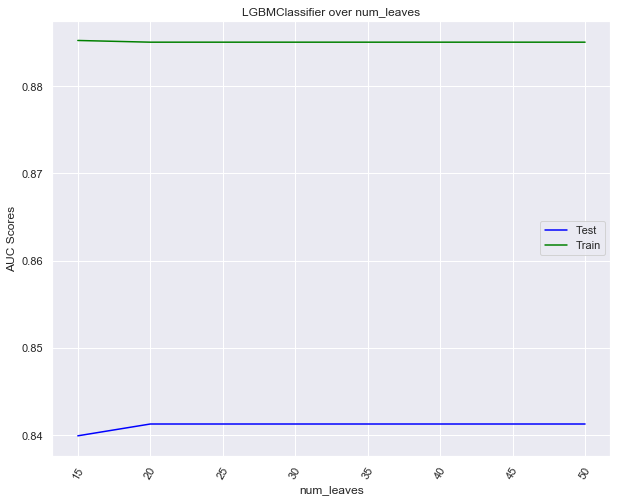

In [170]:
model = LGBMClassifier(
    random_state=42,
    categorical_feature=cat_cols,
    max_depth=5,
    min_data_in_leaf=175
)

parameters = {'num_leaves': range(15, 51, 5)}

grid_classifier(model, train_x, train_y, parameters)

#### N Estimators (Depth=5)

Seconds to fit: 46.29
Grid Scores: 

{'mean_fit_time': array([0.30751457, 0.3717628 , 0.43953099, 0.38433223, 0.43627219,
       0.51667314, 0.53471313, 0.54863477, 0.57938638, 0.58285952,
       0.65296054, 0.81270518, 0.78359513, 0.84107442, 0.70291862,
       0.76056461, 0.76798353, 0.80032325, 0.83965139, 1.17421489,
       1.34699101, 0.99567962, 1.0053637 , 0.99289198, 1.00834103,
       1.0554523 , 1.32094536, 1.63331761, 1.55125504, 1.31878519,
       1.46352091, 1.51530304, 1.71750112, 1.75358734, 1.47050118,
       1.19432364]),
 'mean_score_time': array([0.01667418, 0.01655025, 0.01325727, 0.01647639, 0.01713524,
       0.01488309, 0.01846347, 0.01505127, 0.01505818, 0.01410813,
       0.01656847, 0.01605582, 0.01699171, 0.0180407 , 0.01685801,
       0.01767778, 0.01707978, 0.01825576, 0.01986117, 0.02180643,
       0.01900039, 0.02000794, 0.02028146, 0.02058372, 0.01966395,
       0.01952953, 0.02221985, 0.02917404, 0.02305541, 0.02459345,
       0.02330995, 0.0230052 , 0.

GridSearchCV(cv=5, error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt',
        categorical_feature=[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22, 23],
        class_weight=None, colsample_bytree=1.0, importance_type='split',
        learning_rate=0.1, max_depth=5, min_child_samples=20,
        min_...0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': range(25, 201, 5)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

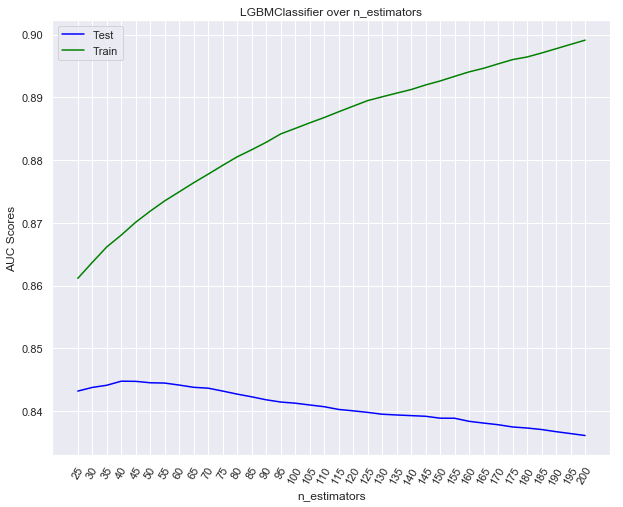

In [171]:
model = LGBMClassifier(
    random_state=42,
    categorical_feature=cat_cols,
    max_depth=5,
    min_data_in_leaf=175
)

parameters = {'n_estimators': range(25, 201, 5)}

grid_classifier(model, train_x, train_y, parameters)

#### Col Sample By Tree (Depth=5)

Seconds to fit: 5.07
Grid Scores: 

{'mean_fit_time': array([0.20369225, 0.20154514, 0.26022191, 0.23340788, 0.22920947,
       0.22970128, 0.22356639, 0.21231399, 0.23237906, 0.25289459,
       0.27429028, 0.31911345, 0.28443685]),
 'mean_score_time': array([0.0172091 , 0.01618814, 0.0171052 , 0.014324  , 0.01739774,
       0.01359148, 0.01395855, 0.01344237, 0.01583672, 0.01289582,
       0.02088127, 0.01568794, 0.01291099]),
 'mean_test_score': array([0.84299522, 0.84336027, 0.84329879, 0.84403414, 0.8443617 ,
       0.84412788, 0.84426297, 0.84386168, 0.84447303, 0.84509653,
       0.84407844, 0.84422904, 0.8446431 ]),
 'mean_train_score': array([0.85537765, 0.85531541, 0.85644002, 0.85668012, 0.85704382,
       0.85703219, 0.8572004 , 0.85702546, 0.85720845, 0.85775829,
       0.85740603, 0.85738475, 0.85735191]),
 'param_colsample_bytree': masked_array(data=[0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85,
                   0.8999999999999999, 0.95, 1.0],
             mask

GridSearchCV(cv=5, error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt',
        categorical_feature=[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22, 23],
        class_weight=None, colsample_bytree=1.0, importance_type='split',
        learning_rate=0.1, max_depth=3, min_child_samples=20,
        min_...0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'colsample_bytree': array([0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 ,
       0.95, 1.  ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

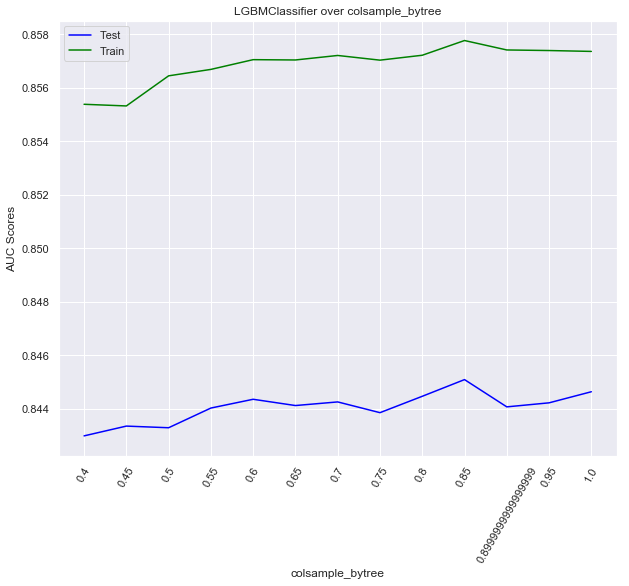

In [172]:
model = LGBMClassifier(
    random_state=42,
    categorical_feature=cat_cols,
    max_depth=3,
    min_data_in_leaf=175,
    n_estimators=40
)

parameters = {'colsample_bytree': np.linspace(0.4, 1.0, 13)}

grid_classifier(model, train_x, train_y, parameters)

#### Final LightGBM Model (Depth=5)

Seconds to fit: 0.52
Grid Scores: 

{'mean_fit_time': array([0.20394053]),
 'mean_score_time': array([0.01266613]),
 'mean_test_score': array([0.85403172]),
 'mean_train_score': array([0.87606492]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.86253648]),
 'split0_train_score': array([0.87588996]),
 'split1_test_score': array([0.86995379]),
 'split1_train_score': array([0.87288034]),
 'split2_test_score': array([0.8377889]),
 'split2_train_score': array([0.88034472]),
 'split3_test_score': array([0.85434977]),
 'split3_train_score': array([0.87675146]),
 'split4_test_score': array([0.84543586]),
 'split4_train_score': array([0.8744581]),
 'std_fit_time': array([0.05275714]),
 'std_score_time': array([0.00194172]),
 'std_test_score': array([0.0115239]),
 'std_train_score': array([0.00251165])}
Best Model Parameters: {}
Best Model Score: 0.8540


GridSearchCV(cv=5, error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt',
        categorical_feature=[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22, 23],
        class_weight=None, colsample_bytree=0.85, importance_type='split',
        learning_rate=0.1, max_depth=3, min_child_samples=20,
        min...0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

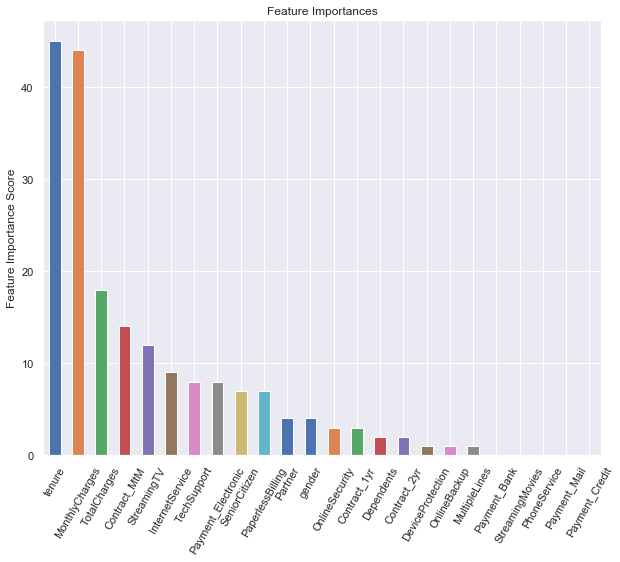

In [173]:
model = LGBMClassifier(
    random_state=42,
    categorical_feature=cat_cols,
    max_depth=3,
    min_data_in_leaf=175,
    n_estimators=40,
    colsample_bytree=0.85
)

grid_classifier(model, test_x, test_y, feat_imp=True)

### Depth Conclusion
|  Depth  |  AUC   |
|---------|--------|
|    2    | 0.8558 |
|    3    | 0.8563 |
|    5    | 0.8540 |

Turns out that 3 is better and 5 is the worst of the bunch. Neat. At least I was right to not stick with 2.

#### Learning Rate

Results:

| factor | trees | rate  | AUC    |
|--------|-------|-------|--------|
| 2/3    | 40    | 0.15  | 0.8445 |
| 1      | 60    | 0.1   | 0.8454 |
| 1.5    | 90    | 0.067 | 0.8449 |
| 2      | 120   | 0.05  | 0.8446 |
| 4      | 240   | 0.025 | 0.8452 |

Once again the default learning rate takes the cake

In [174]:
model = LGBMClassifier(
    random_state=42,
    categorical_feature=cat_cols,
    max_depth=3,
    min_data_in_leaf=165,
    n_estimators=40,
    colsample_bytree=0.6,
    learning_rate=0.15
)

grid_classifier(model, train_x, train_y)

Seconds to fit: 0.75
Grid Scores: 

{'mean_fit_time': array([0.23469844]),
 'mean_score_time': array([0.01625581]),
 'mean_test_score': array([0.8445128]),
 'mean_train_score': array([0.86119938]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.86589291]),
 'split0_train_score': array([0.85746201]),
 'split1_test_score': array([0.84248391]),
 'split1_train_score': array([0.86091801]),
 'split2_test_score': array([0.83570907]),
 'split2_train_score': array([0.86410149]),
 'split3_test_score': array([0.83411394]),
 'split3_train_score': array([0.86193834]),
 'split4_test_score': array([0.84434586]),
 'split4_train_score': array([0.86157707]),
 'std_fit_time': array([0.05275636]),
 'std_score_time': array([0.00262167]),
 'std_test_score': array([0.01137618]),
 'std_train_score': array([0.00215212])}
Best Model Parameters: {}
Best Model Score: 0.8445


GridSearchCV(cv=5, error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt',
        categorical_feature=[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22, 23],
        class_weight=None, colsample_bytree=0.6, importance_type='split',
        learning_rate=0.15, max_depth=3, min_child_samples=20,
        min...0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [175]:
model = LGBMClassifier(
    random_state=42,
    categorical_feature=cat_cols,
    max_depth=3,
    min_data_in_leaf=165,
    n_estimators=60,
    colsample_bytree=0.6,
    learning_rate=0.1
)

grid_classifier(model, train_x, train_y)

Seconds to fit: 0.85
Grid Scores: 

{'mean_fit_time': array([0.30701318]),
 'mean_score_time': array([0.01447897]),
 'mean_test_score': array([0.84536817]),
 'mean_train_score': array([0.86165362]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.86715813]),
 'split0_train_score': array([0.85758001]),
 'split1_test_score': array([0.84311652]),
 'split1_train_score': array([0.86214401]),
 'split2_test_score': array([0.83670544]),
 'split2_train_score': array([0.86386815]),
 'split3_test_score': array([0.83590557]),
 'split3_train_score': array([0.86272976]),
 'split4_test_score': array([0.84393668]),
 'split4_train_score': array([0.86194614]),
 'std_fit_time': array([0.07918576]),
 'std_score_time': array([0.0016983]),
 'std_test_score': array([0.0113729]),
 'std_train_score': array([0.00214395])}
Best Model Parameters: {}
Best Model Score: 0.8454


GridSearchCV(cv=5, error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt',
        categorical_feature=[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22, 23],
        class_weight=None, colsample_bytree=0.6, importance_type='split',
        learning_rate=0.1, max_depth=3, min_child_samples=20,
        min_...0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [177]:
model = LGBMClassifier(
    random_state=42,
    categorical_feature=cat_cols,
    max_depth=3,
    min_data_in_leaf=165,
    n_estimators=90,
    colsample_bytree=0.6,
    learning_rate=0.067
)

grid_classifier(model, train_x, train_y)

Seconds to fit: 0.97
Grid Scores: 

{'mean_fit_time': array([0.41629982]),
 'mean_score_time': array([0.01459246]),
 'mean_test_score': array([0.84489778]),
 'mean_train_score': array([0.86160059]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.86690417]),
 'split0_train_score': array([0.85748049]),
 'split1_test_score': array([0.841722]),
 'split1_train_score': array([0.86217232]),
 'split2_test_score': array([0.83563509]),
 'split2_train_score': array([0.86402164]),
 'split3_test_score': array([0.83480054]),
 'split3_train_score': array([0.8623129]),
 'split4_test_score': array([0.84540928]),
 'split4_train_score': array([0.86201559]),
 'std_fit_time': array([0.08658027]),
 'std_score_time': array([0.00159369]),
 'std_test_score': array([0.01168409]),
 'std_train_score': array([0.00218372])}
Best Model Parameters: {}
Best Model Score: 0.8449


GridSearchCV(cv=5, error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt',
        categorical_feature=[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22, 23],
        class_weight=None, colsample_bytree=0.6, importance_type='split',
        learning_rate=0.067, max_depth=3, min_child_samples=20,
        mi...0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [178]:
model = LGBMClassifier(
    random_state=42,
    categorical_feature=cat_cols,
    max_depth=3,
    min_data_in_leaf=165,
    n_estimators=120,
    colsample_bytree=0.6,
    learning_rate=0.05
)

grid_classifier(model, train_x, train_y)

Seconds to fit: 1.43
Grid Scores: 

{'mean_fit_time': array([0.5737349]),
 'mean_score_time': array([0.01696048]),
 'mean_test_score': array([0.84459371]),
 'mean_train_score': array([0.86152692]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.86550734]),
 'split0_train_score': array([0.85713687]),
 'split1_test_score': array([0.8425093]),
 'split1_train_score': array([0.86249572]),
 'split2_test_score': array([0.83531144]),
 'split2_train_score': array([0.86315644]),
 'split3_test_score': array([0.83463178]),
 'split3_train_score': array([0.86270839]),
 'split4_test_score': array([0.84499085]),
 'split4_train_score': array([0.86213717]),
 'std_fit_time': array([0.13166623]),
 'std_score_time': array([0.00237404]),
 'std_test_score': array([0.01120235]),
 'std_train_score': array([0.00221967])}
Best Model Parameters: {}
Best Model Score: 0.8446


GridSearchCV(cv=5, error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt',
        categorical_feature=[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22, 23],
        class_weight=None, colsample_bytree=0.6, importance_type='split',
        learning_rate=0.05, max_depth=3, min_child_samples=20,
        min...0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [179]:
model = LGBMClassifier(
    random_state=42,
    categorical_feature=cat_cols,
    max_depth=3,
    min_data_in_leaf=165,
    n_estimators=240,
    colsample_bytree=0.6,
    learning_rate=0.025
)

grid_classifier(model, train_x, train_y)

Seconds to fit: 2.29
Grid Scores: 

{'mean_fit_time': array([1.20254025]),
 'mean_score_time': array([0.0235044]),
 'mean_test_score': array([0.84517689]),
 'mean_train_score': array([0.86180491]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.86640777]),
 'split0_train_score': array([0.85707693]),
 'split1_test_score': array([0.84289949]),
 'split1_train_score': array([0.86260998]),
 'split2_test_score': array([0.83574143]),
 'split2_train_score': array([0.86379365]),
 'split3_test_score': array([0.83538773]),
 'split3_train_score': array([0.86316005]),
 'split4_test_score': array([0.84543008]),
 'split4_train_score': array([0.86238394]),
 'std_fit_time': array([0.37268857]),
 'std_score_time': array([0.00691201]),
 'std_test_score': array([0.01132295]),
 'std_train_score': array([0.00241366])}
Best Model Parameters: {}
Best Model Score: 0.8452


GridSearchCV(cv=5, error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt',
        categorical_feature=[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22, 23],
        class_weight=None, colsample_bytree=0.6, importance_type='split',
        learning_rate=0.025, max_depth=3, min_child_samples=20,
        mi...0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

#### Final LightGBM Model

In [181]:
model = LGBMClassifier(
    random_state=42,
    categorical_feature=cat_cols,
    max_depth=3,
    min_data_in_leaf=165,
    n_estimators=60,
    colsample_bytree=0.6,
    learning_rate=0.1
)

grid_classifier(model, test_x, test_y)

Seconds to fit: 0.93
Grid Scores: 

{'mean_fit_time': array([0.33512855]),
 'mean_score_time': array([0.01302629]),
 'mean_test_score': array([0.85627737]),
 'mean_train_score': array([0.88206393]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.86673152]),
 'split0_train_score': array([0.88229892]),
 'split1_test_score': array([0.86679232]),
 'split1_train_score': array([0.87942813]),
 'split2_test_score': array([0.84124756]),
 'split2_train_score': array([0.88564808]),
 'split3_test_score': array([0.8550415]),
 'split3_train_score': array([0.8829735]),
 'split4_test_score': array([0.85150082]),
 'split4_train_score': array([0.87997101]),
 'std_fit_time': array([0.06938256]),
 'std_score_time': array([0.00210264]),
 'std_test_score': array([0.00969932]),
 'std_train_score': array([0.00223859])}
Best Model Parameters: {}
Best Model Score: 0.8563


GridSearchCV(cv=5, error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt',
        categorical_feature=[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22, 23],
        class_weight=None, colsample_bytree=0.6, importance_type='split',
        learning_rate=0.1, max_depth=3, min_child_samples=20,
        min_...0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)